<a href="https://colab.research.google.com/github/Fanfarillo/progetto-ML/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Room Occupancy Estimation

## Autori
* **Matteo Fanfarillo** 0316179
* **Matteo Federico**   0321569

## Introduzione
Questo Notebook si propone di effettuare un'analisi di molteplici modelli di Machine Learning da applicare al data set "Occupancy_Estimation.csv". Tale data set è stato costruito per predire il numero di persone che si trovano all'interno di una stanza di un ufficio sulla base dei seguenti valori misurati:
* **S1_Temp**, **S2_Temp**, **S3_Temp**, **S4_Temp**: temperatura misurata rispettivamente dai sensori S1, S2, S3, S4;
* **S1_Light**, **S2_Light**, **S3_Light**, **S4_Light**: intensità luminosa misurata rispettivamente dai sensori S1, S2, S3, S4;
* **S1_Sound**, **S2_Sound**, **S3_Sound**, **S4_Sound**: intensità del suono misurata rispettivamente dai sensori S1, S2, S3, S4;
* **S5_CO2**, **S5_CO2_Slope**: metriche sulla quantità di anidride carbonica presente nella stanza, che viene misurata dal sensore S5;
* **S6_PIR**, **S7_PIR**: presenza di movimento rilevata mediante i raggi infrarossi dei sensori S6, S7.

Con riferimento ai dati raccolti, il numero di persone presenti nella stanza (**Room_Occupancy_Count**) oscilla sempre tra 0 e 3.

Per prima cosa, si effettuerà un pre-processamento dei dati, in modo tale che le informazioni all'interno del data set siano ben rappresentate. Dopodiché, si considereranno diversi modelli di Machine Learning da applicare al data set e se ne valuteranno le relative prestazioni.

## Librerie importate
Le principali librerie Python utilizzate per lo svolgimento del progetto sono:
* **Matplotlib** per la creazione di grafici e la visualizzazione di dati;
* **Numpy** per eseguire operazioni matematiche su vettori e matrici;
* **Pandas** per effettuare inserimento, analisi e manipolazione di dati;
* **Seaborn** per la creazione di heatmap;
* **Skfda** per utilizzare e valutare il modello Nadaraya-Watson (richiede il comando _pip install scikit-fda_ per essere installata e importata);
* **Sklearn** per utilizzare e valutare gli altri modelli di Machine Learning.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import drive
from IPython.display import clear_output
from pandas.core.ops import kleene_xor

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
%pip install scikit-fda
clear_output()

from skfda.misc.hat_matrix import KNeighborsHatMatrix, LocalLinearRegressionHatMatrix, NadarayaWatsonHatMatrix
from skfda.ml.regression._kernel_regression import KernelRegression

Il file contenente il data set ("Occupancy_Estimation.csv") è stato caricato all'interno della directory "/content/drive/MyDrive/".

In [ ]:
drive.mount('/content/drive')
path_to_dataset = "/content/drive/MyDrive/Occupancy_Estimation.csv"
df = pd.read_csv(path_to_dataset, sep=",")

Mounted at /content/drive


## Pre-processamento dei dati
Per prima cosa, è opportuno pre-processare i dati del nostro data set in modo tale che potranno essere trattati al meglio. Questa fase non dovrebbe risultare troppo complessa in quanto i dati sono già ben formati. In particolare:
* Le feature sono 16 (senza conteggiare data, ora e il target) e sono tutte e 16 numeriche.
* Non esistono valori nulli in alcuna feature.

Per queste ragioni, non sarà necessario effettuare alcun trattamento per i valori nulli ed è preferibile evitare di effettuare una riduzione della dimensionalità a priori, dato che 16 feature sono già poco numerose. Al più, possiamo evitare di considerare data e ora come feature: di fatto, tutte le misurazioni sono state effettuate in date e orari in cui l'ufficio era normalmente accessibile, per cui è possibile assumere che data e ora siano due informazioni indipendenti dal numero di persone presenti all'interno della stanza. \
Comunque sia, è possibile impostare il progetto in modo tale da valutare i modelli di Machine Learning inizialmente sulle 16 feature originali e solo successivamente su un insieme di feature ristretto (e.g. ottenuto tramite PCA - Principal Component Analysis), per poi confrontare i risultati tra i due casi.
In definitiva, la fase di pre-processamento dei dati consisterà nella normalizzazione delle feature e nella suddivisione del data set in training+validation set e testing set.

### Normalizzazione delle feature
Affinché tutte le feature diano lo stesso contributo nell'apprendimento dei modelli di Machine Learning, è necessario che i loro valori viaggino sullo stesso ordine di grandezza. Invece noi abbiamo:
* **S1_Temp**, **S2_Temp**, **S3_Temp**, **S4_Temp** contengono valori per lo più compresi tra 20 e 30.
* **S1_Light**, **S2_Light**, **S3_Light**, **S4_Light** contengono valori per lo più compresi tra 0 e 255.
* **S1_Sound**, **S2_Sound**, **S3_Sound**, **S4_Sound** contengono molti valori dell'ordine dei decimi o dei centesimi e alcuni valori dell'ordine di qualche unità.
* **S5_CO2** contiene valori per lo più compresi tra 300 e 900.
* **S5_CO2_Slope** contiene valori sia positivi che negativi che si aggirano nell'ordine di grandezza delle unità.
* **S6_PIR**, **S7_PIR** contengono soltanto i valori appartenenti all'insieme {0, 1}.

In definitiva, poiché i valori di feature diverse risultano essere relativamente distanti tra loro (con qualche ordine di grandezza di differenza), è opportuno effettuare una normalizzazione delle feature. \
In particolare, verrà adottata una normalizzazione che riporterà i valori di tutte le feature all'interno dell'intervallo [0, 1], dove 0 corrisponde al valore minimo assunto da ciascuna feature, mentre 1 corrisponde al valore massimo. \
Sia $x$ il valore originale di una particolare feature $f$, sia $x'$ il valore ottenuto a seguito della normalizzazione e siano $min$, $max$ rispettivamente il valore minimo e il valore massimo assunti dalla feature f all'interno del data set. Allora, la normalizzazione avviene secondo la seguente formula:

$$ x' = \frac{x-min}{max-min} $$

In [ ]:
def normalize_feature(feature_name):
  try:
    #i valori dei target non devono essere normalizzati
    if feature_name == "Room_Occupancy_Count":
      return

    #applicazione della formula di normalizzazione per le 16 feature numeriche.
    max = np.max(df[feature_name])
    min = np.min(df[feature_name])
    df[feature_name]=(df[feature_name]-min)/(max-min)

  #i valori non numerici (i.e. data e ora) non devono essere normalizzati (tant'è vero che non verranno considerate come feature)
  except TypeError:
    return



for i in df.columns:
  normalize_feature(i)

### Controllo del bilanciamento delle classi
Un'altra operazione preliminare che si potrebbe effettuare è verificare in quale proporzione compaiono le classi 0, 1, 2, 3 all'interno del data set. Dopodiché, si può mostrare tale proporzione su un grafico a torta.

Total number of elements: 10129
Class 0 - (number of elements, number of columns): (8228, 19)
Class 1 - (number of elements, number of columns): (459, 19)
Class 2 - (number of elements, number of columns): (748, 19)
Class 3 - (number of elements, number of columns): (694, 19)


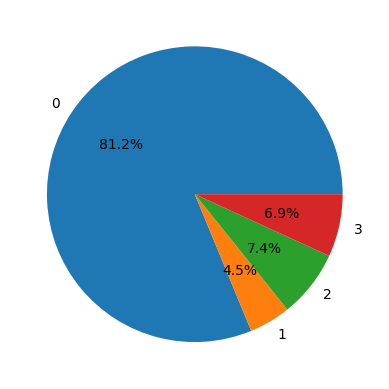

In [ ]:
#controllo bilanciamento classi
def check_bilanciamento_classi(df):
  numRow = df.shape[0]
  print("Total number of elements:", numRow)
  vetNumRow=[]  #lista che conterrà il numero di elementi appartenenti a ciascuna delle 4 classi
  for i in range(0,4):
    vetNumRow.append(df[df["Room_Occupancy_Count"]==i].shape[0])
    print("Class", i, "-", "(number of elements, number of columns):", df[df["Room_Occupancy_Count"]==i].shape)
  plt.pie(np.array(vetNumRow),labels=[0,1,2,3],autopct='%1.1f%%')
  plt.show()
  return vetNumRow



#ottenimento della lista contenente il numero di elementi appartenenti a ciascuna delle 4 classi
vetNumRow=check_bilanciamento_classi(df)

Dal grafico è emerso che c'è un'importante prevalenza della classe 0 rispetto alle altre classi. In linea di principio, potrebbe essere utile effettuare un ribilanciamento degli elementi del data set in modo tale che tutte le classi compaiano per circa $\frac{1}{4}$ delle istanze. Tuttavia, almeno per il momento, non applichiamo alcun ribilanciamento, in modo tale da mantenere il data set fedele alle misurazioni (e quindi ai dati) originali.

### Suddivisione del data set in training+validation set e testing set
Quando si valuta un modello di Machine Learning, l'intero data set deve essere scomposto in 3 parti:
* **training set**: porzione del data set utilizzata per addestrare il modello;
* **validation set**: porzione del data set utilizzata per stabilire quali sono i valori degli iperparametri che portano il modello ad avere le prestazioni migliori.
* **testing set**: porzione del data set utilizzata per effettuare le predizioni, confrontare il valore vero col valore predetto del target di ciascun elemento e calcolare le prestazioni e la qualità del modello.

Stando alla documentazione di Sklearn, il data set viene tipicamente suddiviso secondo il seguente schema:
* Si ha una prima suddivisione statica in training+validation set e testing set: circa il 70-80% delle istanze andrebbe nel training+validation set, mentre il restante 20-30% andrebbe nel testing set. In questo progetto, verrà effettuata una suddivisione del tipo: 80% dei dati nel training+validation set; 20% dei dati nel testing set.
* Per quanto riguarda il training+validation set, nel caso in cui si ha a che fare con un modello che prevede il settaggio di qualche iperparametro, è necessario un meccanismo per applicare un'ulteriore suddivisione in training set e validation set. Questa seconda suddivisione avviene sulla base della k-fold cross validation: il training+validation set viene diviso in $k$ porzioni uguali e vengono effettuate $k$ iterazioni, in ciascuna delle quali una sola porzione (diversa a ogni iterazione) svolge il ruolo di validation set, mentre le altre $k-1$ svolgono il ruolo di training set.

Per quanto riguarda la suddivisione dell'intero data set in training+validation set e testing set, inizialmente si è pensato di riservare il primo 80% dei dati in ordine temporale al training+validation set e gli elementi restanti al testing set. Tuttavia, così facendo, per il testing set (e, di conseguenza, per il training+validation set), le classi 0, 1, 2, 3 compaiono con una proporzione profondamente diversa rispetto al data set completo: in particolare, la classe 1 è del tutto assente dal testing set, il che è indice di una cattiva suddivisione.

Total number of elements: 8084
Class 0 - (number of elements, number of columns): (6477, 19)
Class 1 - (number of elements, number of columns): (459, 19)
Class 2 - (number of elements, number of columns): (655, 19)
Class 3 - (number of elements, number of columns): (493, 19)


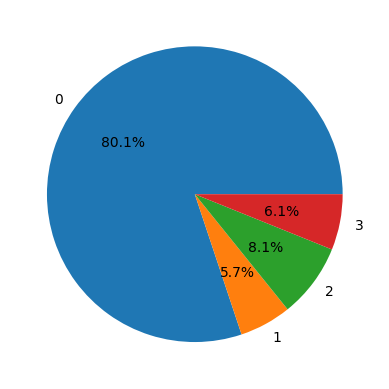

Total number of elements: 2045
Class 0 - (number of elements, number of columns): (1751, 19)
Class 1 - (number of elements, number of columns): (0, 19)
Class 2 - (number of elements, number of columns): (93, 19)
Class 3 - (number of elements, number of columns): (201, 19)


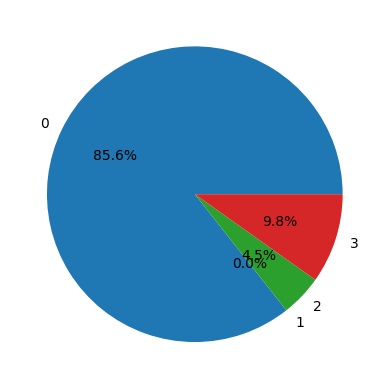

[1751, 0, 93, 201]

In [ ]:
#divisione del dataset in Training Set e Testing Set

#prima divisione del dataset
trainingValidationSet = df[df["Date"]<"2018/01/01"] #circa l'80% degli elementi è associato a una data precedente al 01/01/2018
testingSet = df[df["Date"]>="2018/01/01"]

check_bilanciamento_classi(trainingValidationSet)
check_bilanciamento_classi(testingSet)


In [ ]:
df = df.iloc[:,2:] #Elimino le colonne di data e ora

Per mantenere le proporzioni con cui compaiono le 4 classi sia nel training+validation set sia nel testing set, si è deciso di comporre il testing set estraendo l'ultimo 20% degli elementi relativi a ciascuna classe (e non l'ultimo 20% degli elementi in assoluto); il training+validation set, chiaramente, sarà l'insieme complementare.

Total number of elements: 2027
Class 0 - (number of elements, number of columns): (1646, 17)
Class 1 - (number of elements, number of columns): (92, 17)
Class 2 - (number of elements, number of columns): (150, 17)
Class 3 - (number of elements, number of columns): (139, 17)


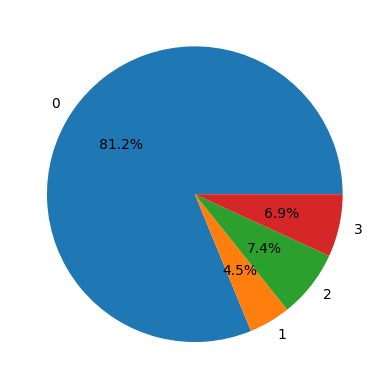

Total number of elements: 8102
Class 0 - (number of elements, number of columns): (6582, 17)
Class 1 - (number of elements, number of columns): (367, 17)
Class 2 - (number of elements, number of columns): (598, 17)
Class 3 - (number of elements, number of columns): (555, 17)


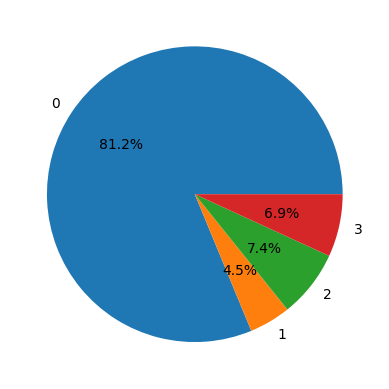

In [ ]:
#seconda divisione del data set

#creazione di testingSet
l=[]
for i in range(0,4):
  l.append(df[df["Room_Occupancy_Count"]==i].iloc[int(vetNumRow[i]*8/10):,:])
testingSet=pd.concat(l)

#creazione di trainingValidationSet
trainingValidationSet = df[~df.index.isin(testingSet.index)]

check_bilanciamento_classi(testingSet)
check_bilanciamento_classi(trainingValidationSet)

#ottenimento di: feature di trainingValidationSet; target di trainingValidationSet; feature di testingSet; target di testingSet
X_training = trainingValidationSet.iloc[:,:-1]
Y_training = trainingValidationSet.iloc[:,-1]
X_testing = testingSet.iloc[:,:-1]
Y_testing = testingSet.iloc[:,-1]

## Valutazione dei modelli di Machine Learning per la classificazione

Gli algoritmi di Machine Learning di classificazione che verranno confrontati sul data set "Occupancy_Estimation.csv" sono elencati qui di seguito:
* Gaussian Linear Discriminant Analysis
* Quadratic Discriminant Analysis (GDA)
* Gaussian Naive Bayes (GNB)
* k-Nearest Neighbors (kNN)
* Kernel Density Estimation (KDE)
* AdaBoost
* Random Forest (RF)
* Support Vector Machine (SVM)
* Softmax
* Multilayer Perceptron

Per confrontare la bontà e le prestazioni di questi algoritmi, si ricorre alle seguenti metriche:
* **Matrice di confusione**: per ogni $i, j$ indica il numero di volte in cui un elemento di classe $i$ è stato predetto come appartenente della classe $j$.
* **F1-score**: è un valore compreso tra 0 e 1 ed è pari a: $$ 2 \cdot \frac{precision \cdot recall}{precision + recall} $$
* **Accuracy**: è la percentuale di elementi predetti correttamente.

### Funzioni ausiliarie

In [ ]:
#calcolo_stat() accetta in input i target veri di determinati elementi e i relativi valori predetti
#da un particolare classificatore, e calcola la matrice di confusione, l'f1-score e l'accuracy.
#Questa funzione viene invocata ove non è possibile sfruttare direttamente una funzione di libreria
#(come nel caso della regressione).
def calcolo_stat(Y_true, Y_pred):
  #nel caso specifico della regressione, i valori predetti possono essere dei numeri non interi:
  #poiché vogliamo predire il numero di persone all'interno della stanza (che deve essere intero),
  #è necessario un arrotondamento di questi valori predetti.
  new_y_pred=np.round(Y_pred)

  #itero su tutti gli elementi su cui è stata effettuata la predizione
  for i in range(len(new_y_pred)):
    if  new_y_pred[i]>4:  #ha senso considerare le classi 0, 1, 2, 3, >3
      new_y_pred[i]=4
  new_y_true = Y_true.tolist()

  #calcolo della matrice di confusione
  matrice_confusione=[[0.0,0.0,0.0,0.0,0.0],
                      [0.0,0.0,0.0,0.0,0.0],
                      [0.0,0.0,0.0,0.0,0.0],
                      [0.0,0.0,0.0,0.0,0.0],
                      [0.0,0.0,0.0,0.0,0.0]]
  for i in range(len(new_y_pred)):
    matrice_confusione[new_y_true[i]][int(new_y_pred[i])]+=1.0

  #calcolo dell'accuracy = (#elementi predetti correttamente)/(#elementi totali) =
  # = (somma componenti sulla diagonale principale)/(#elementi totali)
  accur=0.0
  for i in range(0,4):
    accur+=matrice_confusione[i][i]
  accur=accur/len(new_y_pred)

  #calcolo di precision e recall per le classi 0, 1, 2, 3
  list_precision=[]
  list_recall=[]
  for i in range(0,4):
    precision=0.0
    recall=0.0
    #caso in cui è stato predetto almeno un elemento come appartenente alla classe i (i.e. denominatore della precision != 0)
    if matrice_confusione[0][i]+matrice_confusione[1][i]+matrice_confusione[2][i]+matrice_confusione[3][i] !=0:
      precision=matrice_confusione[i][i]/(matrice_confusione[0][i]+matrice_confusione[1][i]+matrice_confusione[2][i]+matrice_confusione[3][i])
    #caso in cui esiste almeno un elemento realmente appartenente alla classe i (i.e. denominatore della recall != 0)
    if matrice_confusione[i][0]+matrice_confusione[i][1]+matrice_confusione[i][2]+matrice_confusione[i][3] !=0:
      recall=matrice_confusione[i][i]/(matrice_confusione[i][0]+matrice_confusione[i][1]+matrice_confusione[i][2]+matrice_confusione[i][3])
    list_precision.append(precision)
    list_recall.append(recall)

  #calcolo di precision e recall complessive come medie di precision e recall delle singole classi
  total_recall=np.sum(list_recall)/4
  total_precision=np.sum(list_precision)/4

  #calcolo di F1-score (complessivo per tutte le classi)
  f1_score = 0.0
  #caso in cui denominatore dell'F1-score != 0
  if total_recall != 0 or total_precision != 0:
    f1_score=2*(total_recall*total_precision)/(total_recall+total_precision)

  #normalizzazione della matrice di confusione
  for i in range(0,len(matrice_confusione)):
    sum = 0.0
    for j in range(0,len(matrice_confusione[i])):
      sum += matrice_confusione[i][j]
    if sum!=0.0:
      for j in range(0,len(matrice_confusione[i])):
        matrice_confusione[i][j] = matrice_confusione[i][j]/sum

  return {"test_f1_macro":f1_score, "test_accuracy":accur, "confusion_matrix":matrice_confusione}

In [ ]:
#cross_validate_regr effettua uno split (in k porzioni) del training+validation set.
#In ciascuna iterazione della cross validation, calcola i valori di F1-score e accuracy,
#e restituisce i valori medi di F1-score e accuracy rispetto alle k fold.
#Tale funzione serve solo per i predittori che non restituiscono le metriche come F1-score
#e accuracy nell'ambito della cross validation (e.g. i regressori).
def cross_validate_regr(regressor, X, Y, cv=5):
  f1 = 0.0
  accuracy = 0.0

  skf = StratifiedKFold(n_splits=cv)

  for train_index, test_index in skf.split(X, Y):
    #training del modello sulle k-1 fold del training set
    regressor.fit(X.iloc[train_index].to_numpy(), Y.iloc[train_index].to_numpy())
    Y_pred = regressor.predict(X.iloc[test_index].to_numpy()) #predizione
    result = calcolo_stat(Y.iloc[test_index].to_numpy(), Y_pred)
    f1 += result["test_f1_macro"]
    accuracy += result["test_accuracy"]

  return {"test_f1_macro": f1/cv, "test_accuracy": accuracy/cv}

In [ ]:
class best_classifier_info:
  def __init__(self, isClassifier=True):
    self.max={"f1": -1, "accuracy": -1}   #F1-score e accuracy del predittore migliore
    self.best_index=()                    #parametri del predittore migliore
    self.result_list=[]                   #lista che servirà per rappresentare su un grafico l'andamento di F1 e accuracy al variare dei parametri
    self.classifier=isClassifier          #booleano che indica se abbiamo a che fare con un classificatore o no. Serve a stabilire quale funzione di cross validation deve essere invocata (di libreria vs scritta a mano).



  #udpate() viene invocata ogni volta che si prova una nuova combinazione di valori di iperparametri.
  def update(self, classifier, index):
    if self.classifier == True:
      result = cross_validate(classifier, X_training, Y_training, scoring=("f1_macro","accuracy"), cv=5) #cross validation
    else:
      result = cross_validate_regr(classifier, X_training, Y_training, cv=5)
    f1 = np.mean(result["test_f1_macro"])         #estrazione dell'F1-score
    accuracy = np.mean(result["test_accuracy"])   #estrazione dell'accuracy
    self.result_list.append([index, {"f1":f1, "accuracy":accuracy}])

    #check su se le prestazioni sono le migliori per la combinazione dei valori degli iperparametri corrente
    if self.max["f1"] < f1 or (self.max["f1"]==f1 and self.max["accuracy"]<accuracy):
      self.max["f1"] = f1
      self.max["accuracy"] = accuracy
      self.best_index=index



  def print_info(self):
    print("SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE")
    print("Best classifier parameters:", self.best_index)
    print("F1-score:", self.max["f1"])
    print("Accuracy:", self.max["accuracy"])
    print("")



  #metodi getter
  def get_max_f1(self):
    return self.max["f1"]

  def get_max_accuracy(self):
    return self.max["accuracy"]

  def get_best_index(self):
    return self.best_index

  def get_result_list(self):
    return self.result_list

In [ ]:
#confusion_matrix_plot() plotta in modo carino la matrice di confusione passata in input.
def confusion_matrix_plot(m):
  disp = ConfusionMatrixDisplay(confusion_matrix=m, display_labels=[x for x in range(0,len(m))]) #usa cmap per specificare i colori
  disp.plot()
  plt.show()



#stampa_metriche è una funzione che implementa il calcolo e la stampa delle metriche come la matrice di confusione,
#l'F1-score e l'accuracy.
def stampa_metriche(Y_pred, Y_testing, undersampling=False):
  matrice_di_confusione = confusion_matrix(y_true=Y_testing, y_pred=Y_pred, normalize="true")
  matrice_di_confusione = np.around(matrice_di_confusione, decimals=6)
  f1 = f1_score(y_true=Y_testing, y_pred=Y_pred, average="macro")
  accuracy = accuracy_score(y_true=Y_testing, y_pred=Y_pred)

  if undersampling == True:
    title = "METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET" + " (CON UNDER-SAMPLING)"
  else:
    title = "METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET"

  print(title)
  print("Confusion matrix:")
  confusion_matrix_plot(matrice_di_confusione)
  print("")
  print("F1-score:", f1)
  print("Accuracy:", accuracy)

  return {"f1":f1, "accuracy":accuracy}



#calcolo_metriche_classificatore() è una funzione che esegue l'addestramento e la predizione per il classificatore
#passato in input, e ne calcola (e stampa) le metriche come la matrice di confusione, l'F1-score e l'accuracy.
#restituisce un dizionario contenente l'F1-score e l'accuracy ottenuti.
def calcolo_metriche_classificazione(classificatore, X=0, Y=0, X_test=0, Y_test=0):
  #caso undersampling
  if type(X)!=type(0) and type(Y)!=type(0) and type(X_test)!=type(0) and type(Y_test)!=type(0):
    classificatore.fit(X,Y)
    Y_pred = classificatore.predict(X_test)
    return stampa_metriche(Y_pred=Y_pred, Y_testing=Y_test, undersampling=True)

  else: #caso senza undersampling
    classificatore.fit(X_training, Y_training)
    Y_pred = classificatore.predict(X_testing)
    return stampa_metriche(Y_pred=Y_pred, Y_testing=Y_testing, undersampling=False)


In [ ]:
#plot grafici k-Nearest Neighbors
def plot_xy_graphics_knn(l1, l2, weights, N, j):
  #plot grafico 1 (dove k varia tra le sole potenze di 2)
  plt.plot(l1, marker='o')  #marker='o' disegna i puntini sul grafico.
  plt.title("F1-score and accuracy for weigths = " + weights)
  plt.xlabel("k")
  ticks_position = [x for x in range(0,N)]
  ticks_label = [2**t for t in ticks_position]
  plt.xticks(ticks_position, ticks_label, rotation=45)
  plt.ylabel("YELLOW = accuracy - BLUE = F1-score")
  plt.show()

  #plot grafico 2 (dove k varia tra 2**(j-1) e 2**(j+1))
  plt.plot(l2)
  plt.title("F1-score and accuracy for weigths = " + weights)
  plt.xlabel("k")
  ticks_position = [x for x in range(0, 2**(j+1)-2**(j-1), j)]
  ticks_label = [t+2**(j-1) for t in ticks_position]
  plt.xticks(ticks_position, ticks_label, rotation=45)
  plt.ylabel("YELLOW = accuracy - BLUE = F1-score")
  plt.show()



#plot grafico Kernel Density Estimation (è buono anche per Nadaraya-Watson)
def plot_xy_graphic_kde(list_of_kernels, plot_data, xlabel):
  plt.scatter(list_of_kernels, plot_data[0])  #plot_data[0] = F1-score
  plt.scatter(list_of_kernels, plot_data[1])  #plot_data[1] = accuracy
  plt.title("F1-score and accuracy")
  plt.xlabel(xlabel)
  plt.xticks(rotation=45)
  plt.ylabel("YELLOW = accuracy - BLUE = F1-score")
  plt.show()



#plot grafici Support Vector Machine (è buono anche per Softmax)
def plot_xy_graphics_svm(result_list, list_c):
  dict_metrics = {}

  #le result_list sono liste fatte così: [(index), {"f1":f1, "accuracy":accuracy}]
  for item in result_list:
    #caso in cui nel titolo del grafico va specificato anche il grado del polinomio [SVM]
    #caso in cui nel titolo del grafico va specificata anche la penalty (tipo di regolarizzaz) [Softmax]
    if item[0][1] != None and item[0][0] not in ["linear", "rbf", "sigmoid"]:
      key = item[0][0] + " " + str(item[0][1])
    else:
      key = item[0][0]

    #associazione tra le liste di valori di F1-score e accuracy ai corrispondenti item[0][0], item[0][1]
    #(dove ciascuna coppia item[0][0], item[0][1] compone un grafico con ascisse == C e ordinate == F1-score, accuracy)
    if not key in dict_metrics.keys():
      dict_metrics[key] = [[],[]]
    dict_metrics[key][0].append(item[1]["f1"])
    dict_metrics[key][1].append(item[1]["accuracy"])

  #plot del singolo grafico
  for key in dict_metrics.keys():
    plt.plot(list_c, dict_metrics[key][0], label=key+"f1", marker="o")
    plt.plot(list_c, dict_metrics[key][1], label=key+"accuracy", marker="o")
    plt.title(key)
    plt.xlabel("C")
    plt.ylabel("YELLOW = accuracy - BLUE = F1-score")
    plt.show()



#plot grafici multilayer perceptron (iterazione 1)
def plot_xy_graphics_mlp(result_list):
  dict1 = {}  #dizionario delle multilayer configuration
  dict2 = {}  #dizionario delle activation function

  #le result_list sono liste fatte così: [(index), {"f1":f1, "accuracy":accuracy}]
  for item in result_list:
    key1 = item[0][0]       #singola multilayer configuration
    key2 = str(item[0][1])  #singola activation function

    #se serve, viene aggiunta al grafico una nuova multilayer conf con i rispettivi F1-score e accuracy.
    if not key1 in dict1.keys():
        dict1[key1] = [[],[]]
    dict1[key1][0].append(item[1]["f1"])
    dict1[key1][1].append(item[1]["accuracy"])

    #se serve, viene aggiunta al grafico una nuova activation func con i rispettivi F1-score e accuracy.
    if not key2 in dict2.keys():
        dict2[key2] = [[],[]]
    dict2[key2][0].append(item[1]["f1"])
    dict2[key2][1].append(item[1]["accuracy"])

  #plot dei 4 grafici presi singolarmente
  for key in dict1.keys():
      plt.scatter(dict2.keys(), dict1[key][0], label=key)
  plt.title("F1-score wrt multilayer configurations")
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

  for key in dict1.keys():
      plt.scatter(dict2.keys(), dict1[key][1], label=key)
  plt.title("Accuracy wrt multilayer configurations")
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

  for key in dict2.keys():
      plt.scatter(dict1.keys(), dict2[key][0], label=key+"f1")
  plt.title("F1-score wrt activation functions")
  plt.legend()
  plt.show()

  for key in dict2.keys():
      plt.scatter(dict1.keys(), dict2[key][1], label=key+"accuracy")
  plt.title("Accuracy wrt activation functions")
  plt.legend()
  plt.show()

In [ ]:
def plot_heatmap_ensemble_implementation(data, title, x_len, y_len):
  #utilizziamo sns.heatmap() per plottare la heatmap
  sns.heatmap(data,vmin=0.5,vmax=1.0, cmap='coolwarm', annot=True, fmt=".3f")
  #sistemazione di titolo + label degli assi del grafico
  plt.title(title)
  ticks_position_y = [y for y in range(0,y_len)]
  ticks_label_y = [10*(t+1) for t in ticks_position_y]
  plt.yticks(ticks_position_y, ticks_label_y, rotation=0, verticalalignment='top')
  ticks_position_x = [x for x in range(0,x_len)]
  ticks_label_x = [t+1 for t in ticks_position_x]
  plt.xticks(ticks_position_x, ticks_label_x, rotation=0, horizontalalignment='left')
  #plot del grafico
  plt.show()



def plot_heatmap_multilayer_implementation(data, title, x_len, y_len):
  #utilizziamo sns.heatmap() per plottare la heatmap
  sns.heatmap(data, vmin=0.5, vmax=1.0, cmap='coolwarm', annot=True, fmt=".3f")
  #sistemazione di titolo + label degli assi del grafico
  plt.title(title)
  ticks_position_y = [y for y in range(0,y_len)]
  ticks_label_y = [10*(t+1) for t in ticks_position_y]
  #plt.yticks(ticks_position_y, ticks_label_y, rotation=0, verticalalignment='top')
  ticks_position_x = [x for x in range(0,x_len)]
  ticks_label_x = [t+1 for t in ticks_position_x]
  #plt.xticks(ticks_position_x, ticks_label_x, rotation=0, horizontalalignment='left')
  #plot del grafico
  plt.show()



#plot_heatmap_ensemble() è una funzione che plotta una heatmap per le metriche dei classificatori
#di tipo ensemble (nel nostro caso AdaBoost e Random Forest).
def plot_heatmap_ensemble(list_result, metric, x_len, y_len, model_name):
  #i[0][0] = criterio
  #i[0][1] = max_deep
  #i[0][2] = num_trees
  #i[1][0] = F1
  #i[1][1] = accuracy

  entropy=[[] for _ in range(y_len)]
  gini=[[] for _ in range(y_len)]
  log=[[] for _ in range(y_len)]

  for i in list_result:
    if i[0][0]=="entropy":
      entropy[int((i[0][2]-10)/10)].append(i[1][metric]) #appendo la metrica (F1-score o accuracy) nella lista relativa al numero di classificatori i[0][2] (allo scorrere di i varia prima la depth e poi il numero di classificatori)
    elif i[0][0]=="gini":
      gini[int((i[0][2]-10)/10)].append(i[1][metric])
    elif i[0][0]=="log_loss":
      log[int((i[0][2]-10)/10)].append(i[1][metric])

  plot_heatmap_ensemble_implementation(entropy, model_name+" - entropy_"+metric+" wrt max_depth and num_estimators", x_len, y_len)
  plot_heatmap_ensemble_implementation(gini, model_name+" - gini_"+metric+" wrt max_depth and num_estimators", x_len, y_len)
  plot_heatmap_ensemble_implementation(log, model_name+" - log_"+metric+" wrt max_depth and num_estimators", x_len, y_len)



#plot_heatmap_multilayer() è una funzione che plotta una heatmap per le metriche dei multilayer
#perceptron (iterazione 2).
def plot_heatmap_multilayer(result_list):
  dict_f1 = {}
  dict_accur = {}

  #le result_list sono liste fatte così: [(index), {"f1":f1, "accuracy":accuracy}]
  for item in result_list:
    key_learning = item[0][0] #item[0][0] = learning rate

    if key_learning not in dict_f1.keys(): #se serve, viene aggiunto un nuovo learning rate al dizionario
      dict_f1[key_learning] = {}           #dove il learning rate è a sua volta un dizionario
    if key_learning not in dict_accur.keys():
      dict_accur[key_learning] = {}

    #se serve, viene aggiunto un nuovo beta2 a ciascun dizionario del learing rate
    if item[0][2] not in dict_f1[key_learning].keys():
      dict_f1[key_learning][item[0][2]] = {} #beta2 è a sua volta un dizionario
    if item[0][2] not in dict_accur[key_learning].keys():
      dict_accur[key_learning][item[0][2]] = {}

    #a questo punto, a ogni combinazione di learning rate, beta2, beta1, associo un F1-score e un'accuracy.
    dict_f1[key_learning][item[0][2]][item[0][1]] = item[1]["f1"]
    dict_accur[key_learning][item[0][2]][item[0][1]] = item[1]["accuracy"]

  for key_learning in dict_f1.keys():
    data_f1 = pd.DataFrame(dict_f1[key_learning])
    data_accur = pd.DataFrame(dict_accur[key_learning])

    plot_heatmap_multilayer_implementation(data_f1, "F1-score wrt beta1, beta2 with learning rate = "+str(key_learning), x_len=5, y_len=6)
    plot_heatmap_multilayer_implementation(data_accur, "Accuracy wrt beta1, beta2 with learning rate = "+str(key_learning), x_len=5, y_len=6)

In [ ]:
#dichiarazione di un dizionario che conterrà le coppie {F1-score, accuracy} (definite a loro volta in appositi dizionari)
#relative alle predizioni effettuate dal classificatore migliore (wrt iperparametri) per ciascun modello, dove le
#predizioni vengono fatte sul testing set a seguito di un addestramento effettuato sul training+validation set
dizionario_result={}

### Gaussian Linear Discriminant Analysis

È un algoritmo di Machine Learning della famiglia dei modelli Gaussian Discriminant Analysis (GDA). Parte dall'ipotesi per cui gli elementi appartenenti a ciascuna classe $C_j$ abbiano una distribuzione gaussiana siffatta (dove $\Sigma$ è una matrice di covarianza uguale per tutte le distribuzioni):
$$ p(x|C_j) = \frac{1}{(2π)^{\frac{d}{2}}|Σ|^{\frac{1}{2}}} e^{-\frac{1}{2}(x-μ_j)^TΣ^{-1}(x-μ_j)} $$

Dopodiché, per ogni classe $j$, il modello si propone di calcolare:

$$ p(C_j|x) = s(log(p(x|C_j)p(C_j))) $$

Gli iperpiani di separazione (lineari) sono dati dalle seguenti condizioni:

$$ p(C_i|x) = p(C_j|x) \space \land \space p(C_i|x) > p(C_k|x) \space\space ∀i,j \neq k $$

Poiché Gaussian Linear Discriminant Analysis è un modello di Machine Learning che non prevede particolari iperparametri, ci limiteremo ad addestrarlo sull'intero training+validation set e a valutare le sue prestazioni sulle predizioni degli elementi del testing set.

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


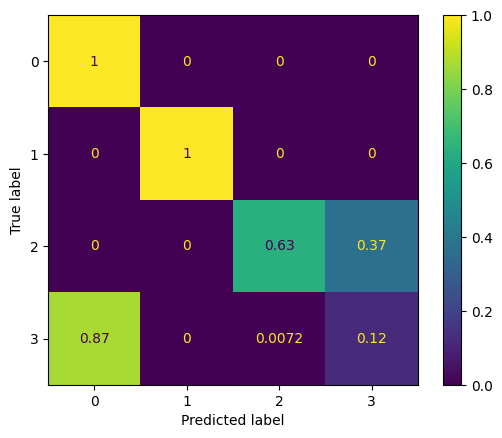


F1-score: 0.7245106208524145
Accuracy: 0.9126788357178096


In [ ]:
#GDA (GAUSSIAN DISCRIMINANT ANALYSIS)
#Ipotesi: p(x|C_k) è gaussiana

GLDA = LinearDiscriminantAnalysis()
dizionario_result["GLDA"] = calcolo_metriche_classificazione(GLDA)

### Quadratic Discriminant Analysis (QDA)
QDA è un altro algoritmo della famiglia dei modelli GDA. Ha lo stesso meccanismo di Gaussian Linear Discriminant Analysis con la differenza che le matrici di covarianza delle distribuzioni degli elementi delle varie classi non sono più tutte uguali per ipotesi:

$$ p(x|C_j) = \frac{1}{(2π)^{\frac{d}{2}}|Σ_j|^{\frac{1}{2}}} e^{-\frac{1}{2}(x-μ_j)^TΣ_j^{-1}(x-μ_j)} $$

Questa differenza comporta che gli iperpiani di separazione trovati non sono più necessariamente lineari, ma possono essere al più quadratici.

Di seguito è riportato un estratto della documentazione di Scikit-learn (https://scikit-learn.org/stable/modules/lda_qda.html) sull'implementazione della Gaussian Linear Discriminant Analysis e della QDA:

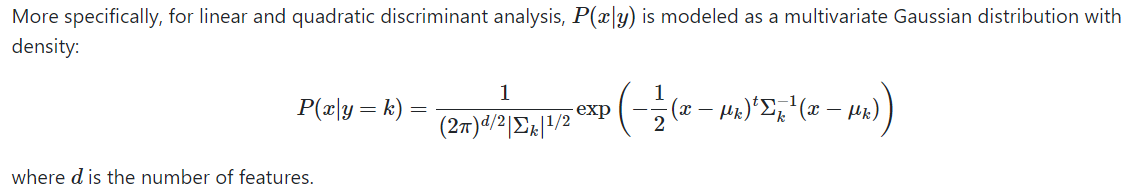

Come Gaussian Linear Discriminant Analysis, anche QDA è un modello di Machine Learning che non prevede particolari iperparametri: di conseguenza, lo valuteremo con le medesime modalità previste per Gaussian Linear Discriminant Analysis.

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


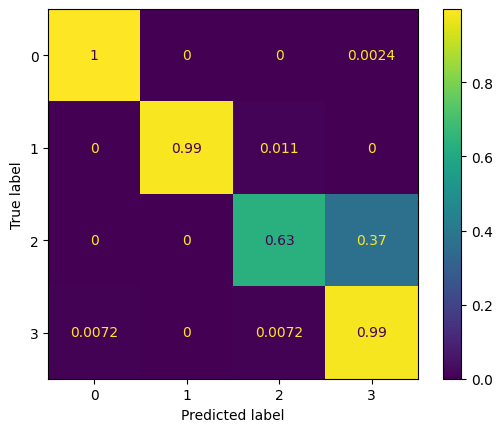


F1-score: 0.8950391293015307
Accuracy: 0.9694129255056734


In [ ]:
#QDA (Quadratic Discriminant Analysis)
QDA = QuadraticDiscriminantAnalysis()
dizionario_result["QDA"] = calcolo_metriche_classificazione(QDA)

### Gaussian Naive Bayes (GNB)
GNB è un modello di machine learning che tratta separatamente le feature degli elementi e assume che i valori di ciascuna feature seguano una distribuzione gaussiana: dato il data set, vengono presi i valori di ciascuna feature degli elementi e, in base a questi, vengono costruite le distribuzioni gaussiane. \
Un'altra informazione che GNB considera è la **probabilità a priori** per gli elementi di appartenere a ciascuna classe $C_j$ (i.e. $p(C_j)$), che viene semplicemente stimata come il rapporto tra il numero di elementi del data set appartenenti a $C_j$ e il numero di elementi del data set totale.

Quando un classificatore GNB deve predire la classe di appartenenza di un certo elemento $x$, lo fa calcolando la **probabilità a posteriori** di appartenere alla classe $C_j$ (i.e. $p(C_j|x)$) per ogni j: di conseguenza, per tutte le classi j, viene effettuato il seguente calcolo:

$$ p(C_j|x) = p(C_j) \cdot L(feature_1 = x_1) \cdot ... \cdot L(feature_d = x_d) $$
dove $L(feature_i = x_i)$ è dato dal valore della densità gaussiana associata alla feature i-esima.

Tra tutti i valori $p(C_j|x)$ ottenuti, si seleziona quello maggiore, il quale determina la classe da predire per l'elemento $x$.

GNB è un ulteriore modello di Machine Learning che non prevede particolari iperparametri: anch'esso verrà valutato con le medesime modalità previste per Gaussian Linear Discriminant Analysis e GDA.

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


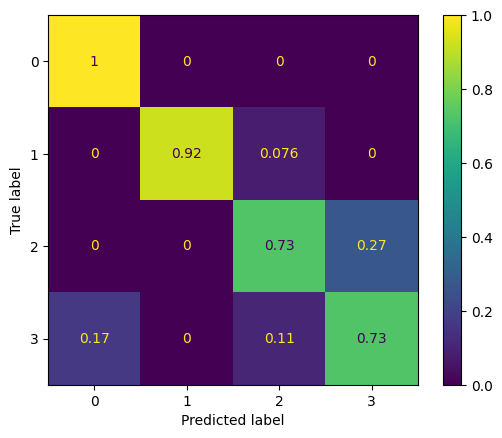


F1-score: 0.8620439348074946
Accuracy: 0.9575727676369018


In [ ]:
#GaussianNB (Gaussian Naive Bayes)
GNB = GaussianNB()
dizionario_result["GNB"] = calcolo_metriche_classificazione(GNB)

### k-Nearest Neighbors (kNN)
kNN è un modello di Machine Learning non parametrico che basa la predizione di un punto $x$ sui k elementi del training set più vicini a lui. In particolare, si basa sull'idea che, dato un elemento $x$, può essere definita una regione $R$ centrata in $x$ e una funzione di densità a essa associata che descrive la distribuzione degli elementi nello spazio:

$$ p(x) = \frac{k}{NV} $$

dove:
* **k** è il numero di elementi del training set appartenenti a $R$;
* **N** è il numero totale di elementi del training set;
* **V** è il volume di $R$.

Nel caso specifico di kNN, la regione è un'iper-sfera di raggio $r_k(x)$, dove $r_k(x)$ è pari alla distanza tra il punto $x$ e il k-esimo elemento del training set più vicino a $x$, ovvero alla lunghezza del raggio della più piccola iper-sfera centrata in $x$ e contenente esattamente k elementi del training set. Di conseguenza, abbiamo che:

$$ p(x) = \frac{k}{N \cdot c_d \cdot r_k^{d}(x)} $$

dove $c_d$ è pari al volume di un'iper-sfera unitaria in uno spazio d-dimensionale.

kNN, per effettuare la predizione su un punto $x$, calcola:

$$ \operatorname*{argmax}_i \space p(C_i|x) = \operatorname*{argmax}_i \space \frac{p(x|C_i) \cdot p(C_i)}{p(x)} = \operatorname*{argmax}_i \space \frac{\frac{k_i}{n_iV}\cdot \frac{n_i}{N}}{\frac{k}{NV}} = \operatorname*{argmax}_i \space \frac{k_i}{k} $$

dove:
* **$n_i$** è il numero di elementi del training set appartenenti alla classe $C_i$;
* **$k_i$** è il numero di elementi del training set della classe $C_i$ compresi nel volume $V$.

Per quanto riguarda l'utilizzo di kNN, sono stati presi in considerazione i seguenti due parametri:
* **$k$**: è il numero di elementi più vicini a quello da valutare che devono essere considerati.
* **Weights**: indica con quali pesi devono essere presi i $k$ elementi più vicini a quello da valutare; le possibilità considerate sono *uniform* (i $k$ elementi vengono presi tutti con lo stesso peso) e *distance* (i $k$ elementi vengono presi con dei pesi dipendenti dalla loro distanza dal punto da valutare).

Sia per *weights = uniform* che per *weights = distance*, la ricerca del valore migliore per l'iperparametro $k$ viene effettuata con l'applicazione della cross validation sul training+validation set e avviene secondo questo schema: \
* Inizialmente si calcolano i valori di F1-score e accuracy per i soli $k$ pari alle potenze di 2 (fino a $k=2^{9}$ per *weights = uniform* e fino a $k=2^{12}$ per *weights = distance*). Il valore di $k$ migliore tra quelli considerati verrà scelto primariamente sulla base dell'F1-score e, in caso di parità tra F1-score, sulla base dell'accuracy.
* Se $k=2^{e_0}$ risulta essere il valore (potenza di 2) migliore, allora si procede con un secondo ciclo in cui si valuta il classificatore (nuovamente con la cross validation) per tutti i $k$ compresi tra $2^{e_0-1}$ e $2^{e_0+1}$. A questo punto, si trova il valore $k=k_1$ per cui presumibilmente il classificatore presenta il comportamento migliore.
* A questo punto, si hanno il valore $k=k_{1-unif}$ migliore per *weights = uniform* e il valore $k=k_{1-dist}$ migliore per *weights = distance*. La configurazione migliore tra le due (sempre sulla base dell'F1-score e, secondariamente, dell'accuracy) è quella che verrà utilizzata per valutare il modello kNN sul testing set.

SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: ('uniform', 41)
F1-score: 0.9363690083579744
Accuracy: 0.9816101172115976

SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: ('distance', 82)
F1-score: 0.9484461606359794
Accuracy: 0.9849418511664039

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


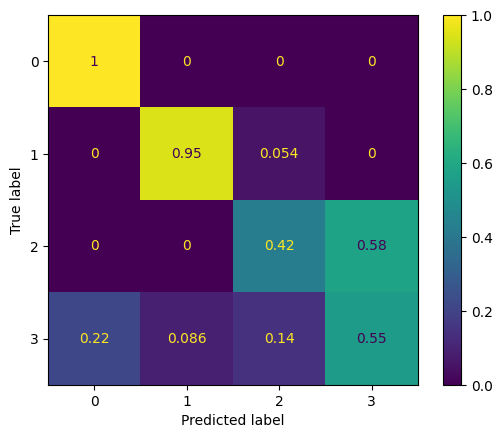


F1-score: 0.7349066624478384
Accuracy: 0.9240256536753824


In [ ]:
#kNN (k-Nearest Neighbors)
def find_best_knn(weights, N):
  knn_info_1 = best_classifier_info()

  for i in range(0,N):
    knn_1 = KNeighborsClassifier(n_neighbors=2**i, weights=weights)
    knn_info_1.update(knn_1, (weights, i))

  best_index_1 = knn_info_1.get_best_index()
  result_list_1 = knn_info_1.get_result_list()

  #sia j il valore di i corrispondente al kNN migliore tra quelli con k = potenza di 2
  #se j==0, allora 2^(j-1)==1/2, il che non può essere un indice
  #per forza di cose si deve partire almeno da k=1 e, quindi, da j=1
  j = best_index_1[1]
  if j==0:
    j=1

  knn_info_2 = best_classifier_info()

  for k in range(2**(j-1), 2**(j+1)): #il ciclo è su tutti i valori da 2^(j-1) a 2^(j+1)
    knn_2 = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knn_info_2.update(knn_2, (weights, k))

  best_index_2 = knn_info_2.get_best_index()
  result_list_2 = knn_info_2.get_result_list()
  max_f1 = knn_info_2.get_max_f1()
  max_accuracy = knn_info_2.get_max_accuracy()

  knn_info_2.print_info() #stampa delle metriche relative alla model selection (cross validation)
  del knn_info_1
  del knn_info_2

  return result_list_1, result_list_2, best_index_2, max_f1, max_accuracy, j



result_list_unif_1, result_list_unif_2, best_index_unif, max_f1_unif, max_accuracy_unif, j_unif = find_best_knn("uniform", 10)
result_list_dist_1, result_list_dist_2, best_index_dist, max_f1_dist, max_accuracy_dist, j_dist = find_best_knn("distance", 13)

#caso in cui è risultato migliore un modello con weights == "distance"
if(max_f1_unif<max_f1_dist or (max_f1_unif==max_f1_dist and max_accuracy_unif<max_accuracy_dist)):
    knn_best = KNeighborsClassifier(n_neighbors=best_index_dist[1], weights=best_index_dist[0])
else: #caso in cui è risultato migliore un modello con weights == "uniform"
    knn_best = KNeighborsClassifier(n_neighbors=best_index_dist[1], weights=best_index_dist[0])

#addestramento su training+validation set ed esecuzione su testing set del miglior predittore
dizionario_result["kNN"] = calcolo_metriche_classificazione(knn_best)

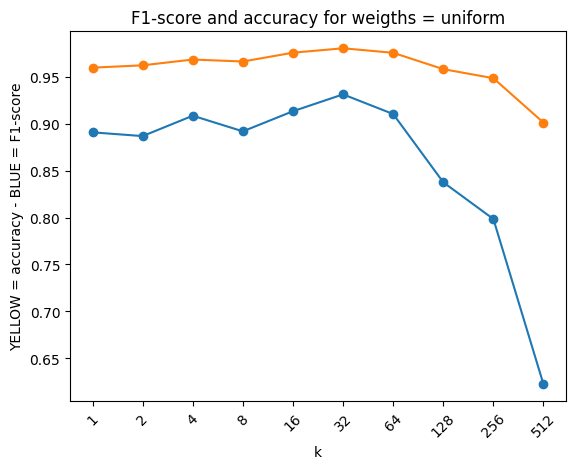

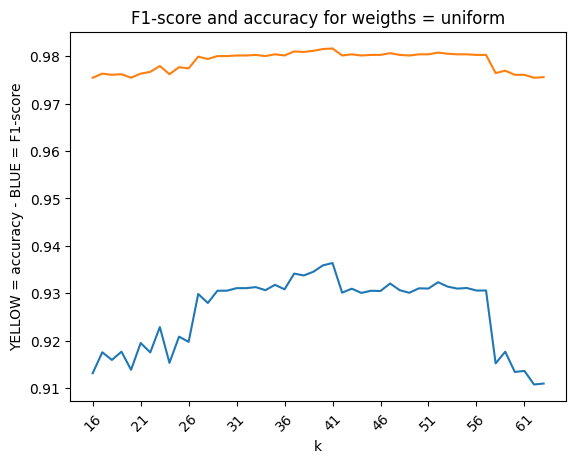

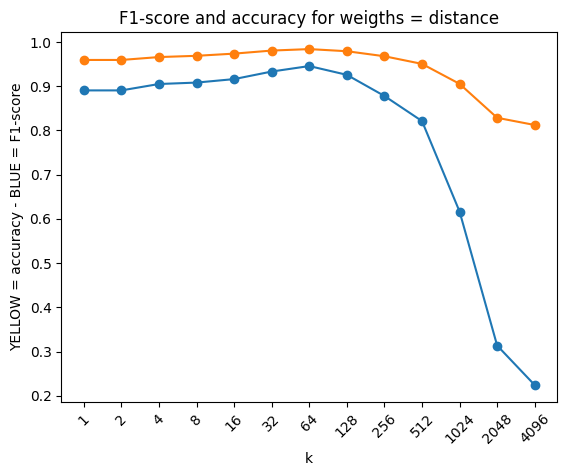

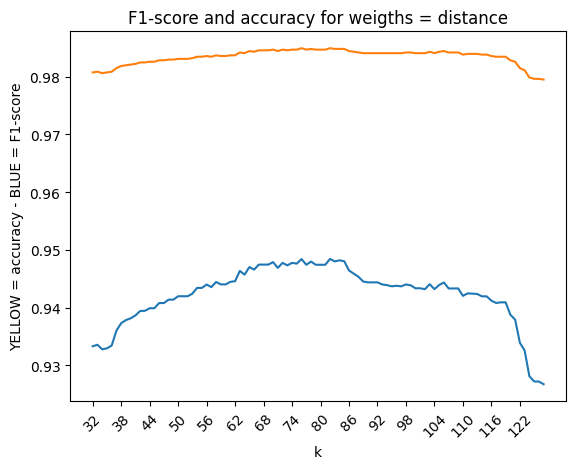

In [ ]:
unif_l1 = []
unif_l2 = []
dist_l1 = []
dist_l2 = []

#le result_list sono liste fatte così: [(index), {"f1":f1, "accuracy":accuracy}]
for item in result_list_unif_1:
  unif_l1.append((item[1]["f1"], item[1]["accuracy"]))
for item in result_list_unif_2:
  unif_l2.append((item[1]["f1"], item[1]["accuracy"]))
for item in result_list_dist_1:
  dist_l1.append((item[1]["f1"], item[1]["accuracy"]))
for item in result_list_dist_2:
  dist_l2.append((item[1]["f1"], item[1]["accuracy"]))

plot_xy_graphics_knn(unif_l1, unif_l2, "uniform", 10, j_unif)
plot_xy_graphics_knn(dist_l1, dist_l2, "distance", 13, j_dist)

### Kernel Density Estimation (KDE)
KDE è un modello di Machine Learning non parametrico che, in modo analogo a kNN, basa la predizione di un punto $x$ sugli elementi del training set più vicini a lui. La differenza sta nel fatto che, anziché fissare il numero k di elementi del training set da considerare, fissa il volume $V$ della regione centrata in $x$ all'interno della quale vi sono gli unici elementi del training set che determineranno la classe predetta per $x$. \
La regione è un iper-cubo di lato $h$, per cui abbiamo che:

$$ p(x) = \frac{\sum_{i=1}^{N} κ(x, x_i)}{N \cdot h^d} $$

dove $κ(x, x_i)$ è una funzione kernel che è tipicamente diversa da 0 per gli elementi $x_i$ del training set che cadono all'interno dell'iper-cubo selezionato.

KDE, per effettuare la predizione su un punto $x$, calcola:

$$ \operatorname*{argmax}_i \space p(C_i|x) = \operatorname*{argmax}_i \space p(x|C_i) \cdot p(C_i) = \operatorname*{argmax}_i \space \frac{ \sum_{j=1}^{n_i} κ(x, x_j)}{n_i \cdot h^d} \cdot \frac{n_i}{N} = \operatorname*{argmax}_i \space \sum_{j=1}^{n_i} κ(x, x_j) $$

Per quanto riguarda l'utilizzo di Kernel Density Estimation, è stato preso in considerazione solo un parametro:
* **Kernel function**: è la funzione kernel utilizzata per dare una misura della distanza tra il punto $x$ da valutare (i.e. il centro della regione considerata) e un punto del training set (i.e. l'input della funzione). Serve per far sì che gli elementi del training set più vicini a $x$ abbiano un peso maggiore ai fini della classificazione di $x$. Le funzioni kernel utilizzabili sono la gaussiana, la Top-hat, la Epanechnikov, l'esponenziale, la lineare e il coseno.

La ricerca del valore migliore dell'iperparametro avviene mediante la cross validation sul training+validation set. Poiché il parametro è solo uno ed è categorico, la ricerca del suo valore migliore è molto semplice: è sufficiente effettuare un confronto tra gli F1-score mediati su tutte le iterazioni della cross validation (e, in caso di parità, tra le accuracy mediate su tutte le iterazioni della cross validation) dei modelli al variare della kernel function. Il modello da valutare sul testing set è quello che dà l'F1-score medio migliore (o, in caso di parità, l'accuracy media migliore).

SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: linear
F1-score: 0.8393167277762492
Accuracy: 0.9422427094995468

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


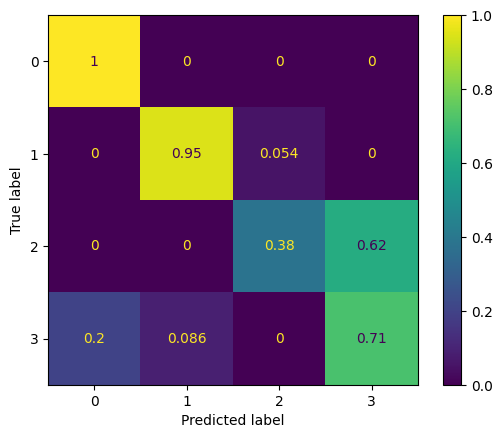


F1-score: 0.7596210474232495
Accuracy: 0.9319190922545634


In [ ]:
#Kernel Density Estimation
cv = 5
max = {"f1":-1, "accuracy":-1}
best_index = ""
plot_data = [[],[]]

#faccio variare i kernel possibili per scegliere il migliore
list_of_kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]

for kernel in list_of_kernels:
  accuracy = 0.0
  f1 = 0.0

  skf = StratifiedKFold(n_splits=cv)

  for train_index, test_index in skf.split(X_training,Y_training):
    #creo i dataset per questo fold
    kf_trainset_X = X_training.values[train_index]
    kf_testset_X = X_training.values[test_index]
    kf_trainset_Y = Y_training.values[train_index]
    kf_testset_Y = Y_training.values[test_index]

    #creo uno stimatore per ogni classe
    kde0 = KernelDensity(kernel=kernel)
    kde1 = KernelDensity(kernel=kernel)
    kde2 = KernelDensity(kernel=kernel)
    kde3 = KernelDensity(kernel=kernel)

    #alleno ogni modello su una classe specifica
    kde0.fit(kf_trainset_X[kf_trainset_Y==0])
    kde1.fit(kf_trainset_X[kf_trainset_Y==1])
    kde2.fit(kf_trainset_X[kf_trainset_Y==2])
    kde3.fit(kf_trainset_X[kf_trainset_Y==3])

    #eseguo le predizioni
    Y_pred = []
    for x in kf_testset_X:
        l=[0,0,0,0]
        l[0] = kde0.score_samples(x.reshape(1, -1))
        l[1] = kde1.score_samples(x.reshape(1, -1))
        l[2] = kde2.score_samples(x.reshape(1, -1))
        l[3] = kde3.score_samples(x.reshape(1, -1))
        Y_pred.append(np.argmax(l)) #predizione = classe più likely secondo il classificatore KDE

    #calcolo le metriche F1-score e accuracy
    f1 += f1_score(y_true=kf_testset_Y, y_pred=Y_pred, average="macro") #F1-score totale sulle k iterazioni della cross validation
    accuracy += accuracy_score(y_true=kf_testset_Y, y_pred=Y_pred)      #accuracy totale sulle k iterazioni della cross validation

  f1 = f1/cv                #F1-score medio sulle k iterazioni della cross validation (fissata la funzione kernel)
  accuracy = accuracy/cv    #accuracy media sulle k iterazioni della cross validation (fissata la funzione kernel)

  #aggiungo alla lista plot_data l'F1-score e l'accuracy relativi alla funzione kernel corrente
  plot_data[0].append(f1)
  plot_data[1].append(accuracy)

  #check su se le prestazioni sono le migliori per la funzione kernel corrente
  if max["f1"] < f1 or (max["f1"]==f1 and max["accuracy"]<accuracy):
    max["f1"] = f1
    max["accuracy"] = accuracy
    best_index=kernel

print("SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE")
print("Best classifier parameters:", best_index)
print("F1-score:", max["f1"])
print("Accuracy:", max["accuracy"])
print("")



#estraggo degli elementi del training+validation set (che ora fa le veci di training set) e del testing set
trainset_X = X_training.values
testset_X = X_testing.values
trainset_Y = Y_training.values
testset_Y = Y_testing.values

#creo uno stimatore per ogni classe
kde0 = KernelDensity(kernel=best_index)
kde1 = KernelDensity(kernel=best_index)
kde2 = KernelDensity(kernel=best_index)
kde3 = KernelDensity(kernel=best_index)

#alleno ogni modello su una classe specifica
kde0.fit(trainset_X[trainset_Y==0])
kde1.fit(trainset_X[trainset_Y==1])
kde2.fit(trainset_X[trainset_Y==2])
kde3.fit(trainset_X[trainset_Y==3])

#eseguo le predizioni
Y_pred = []
for x in testset_X:
    l=[0,0,0,0]
    l[0] = kde0.score_samples(x.reshape(1, -1))
    l[1] = kde1.score_samples(x.reshape(1, -1))
    l[2] = kde2.score_samples(x.reshape(1, -1))
    l[3] = kde3.score_samples(x.reshape(1, -1))
    Y_pred.append(np.argmax(l))

#calcolo le metriche matrice di confusione, F1-score e accuracy
dizionario_result["KDE"] = stampa_metriche(Y_pred, testset_Y)

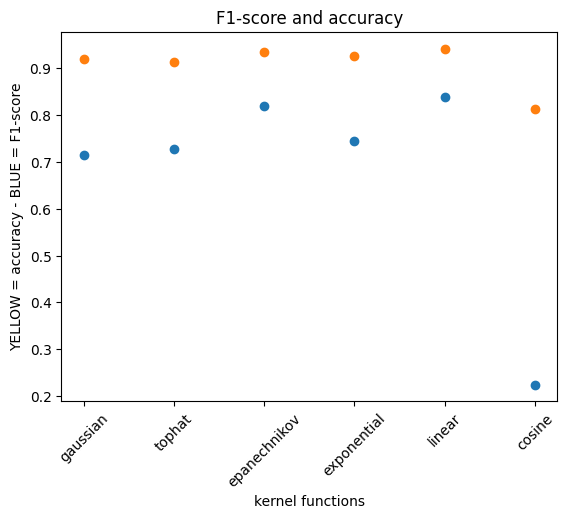

In [ ]:
plot_xy_graphic_kde(list_of_kernels, plot_data, "kernel functions")

### AdaBoost
AdaBoost è un modello ensemble di Machine Learning di tipo boosting: è composto da molteplici predittori che vengono costruiti in modo dipendente l'uno dall'altro, dove, nel nostro caso, i predittori $j$ sono degli alberi decisionali, e differiscono tra loro per i pesi $w_i^{(j)}$ che vengono assegnati ai singoli elementi $x_i$ del training set.

Per il primo decision tree, gli elementi del training set vengono presi tutti con lo stesso peso:

$$ w_i^{(1)} = \frac{1}{n} \space\space\space ∀i ∈ \{1,...,n\} $$

Dopodiché, a ogni iterazione $j$ (i.e. per ogni predittore elementare), si seguono questi passaggi:
* Calcolo di $\pi^{(j)} = \frac{∑_{x_i \in M^{(j)}}w_i^{(j)}}{∑_{i=1}^n w_i^{(j)}}$
* Se $\pi^{(j)} > \frac{1}{2} ⇒$ vengono invertite tutte le predizioni del j-esimo predittore, in modo tale da invertire i valori di $\pi^{(j)}$ e $1-\pi^{(j)}$.
* Calcolo di $α_j = \frac{1}{2}log \left(\frac{1-\pi^{(j)}}{\pi^{(j)}}\right)$, che è il peso da assegnare al j-esimo predittore elementare nel momento in cui si mettono insieme gli output di tutti i decision tree per stabilire il risultato del modello ensemble complessivo.
* Aggiornamento di tutti i pesi per il predittore elementare successivo: $w_i^{(j+1)} = w_i^{(j)}e^{-\alpha_j}$ se il j-esimo decision tree ha azzeccato la predizione sull'i-esimo elemento del data set; $w_i^{(j+1)} = w_i^{(j)}e^{\alpha_j}$ altrimenti.
* Normalizzazione dei pesi di tutti gli elementi del data set per il nuovo classificatore elementare.

Per quanto riguarda l'utilizzo di AdaBoost, sono stati presi degli ensemble composti da decision trees e sono stati considerati i seguenti tre parametri:
* **Max depth**: è l'altezza massima degli alberi decisionali.
* **Estimators number**: è il numero di alberi decisionali che compongono il modello.
* **Criterion**: è una funzione che dà una misura sulla qualità degli split effettuati nello spazio dei punti per costruire ciascun albero decisionale.

La ricerca dei valori migliori degli iperparametri avviene in modo analogo al caso del Kernel Density Estimation, prendendo in esame le combinazioni di alcuni valori dei tre iperparametri. In particolare:
* Max depth varia tra 1 e 5: di fatto, per motivi di efficienza, i classificatori che compongono i modelli ensemble devono essere semplici, per cui non ha senso considerare alberi decisionali con altezze elevate.
* Estimators number varia tra 10 e 150, e si è preferito considerare soltanto i valori multipli di 10: di fatto, si assume che le differenze prestazionali tra un modello ensemble composto da N alberi decisionali e un modello ensemble composto da N+1 alberi decisionali siano esigue.
* Criterion può essere un criterio tra Gini, Entropy e Log loss.

SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: ('entropy', 3, 130)
F1-score: 0.9055572409520627
Accuracy: 0.9740846604367064

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


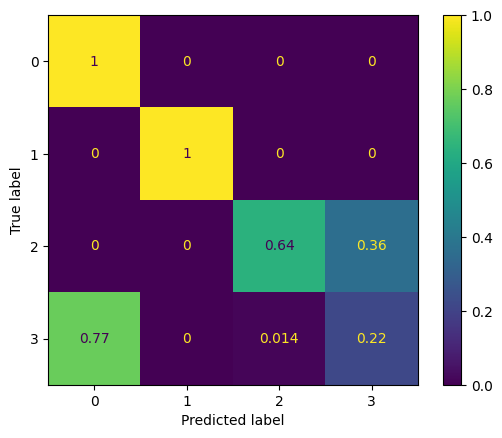


F1-score: 0.7529429993343486
Accuracy: 0.919585594474593


In [ ]:
#classificatore AdaBoost
#il classificatore base che stiamo utilizzando è un decisionTreeClassifier di profondità massima che va da 1 a 5.
lista_criteri=["gini", "entropy", "log_loss"]

abc_info = best_classifier_info()

#faccio variare il valore degli iperparametri per applicare la cross validation e determinare è la configuraz migliore.
for criterio in lista_criteri:
  for max_deep in range(1,6):
    dt = DecisionTreeClassifier(criterion=criterio, max_depth=max_deep, random_state=0)
    for n_tree in range(10,150,10):
      abc = AdaBoostClassifier(dt, n_estimators=n_tree, random_state=0)
      abc_info.update(abc, (criterio, max_deep, n_tree))

best_index = abc_info.get_best_index()
result_list = abc_info.get_result_list()

abc_info.print_info() #stampa di iperparametri, F1-score e accuracy della migliore iterazione della cross validation
dt_best = DecisionTreeClassifier(criterion=best_index[0], max_depth=best_index[1], random_state=0)
abc_best = AdaBoostClassifier(dt_best, n_estimators=best_index[2], random_state=0)
#addestramento su training+validation set ed esecuzione su testing set del miglior predittore
dizionario_result["AdaBoost"] = calcolo_metriche_classificazione(abc_best)

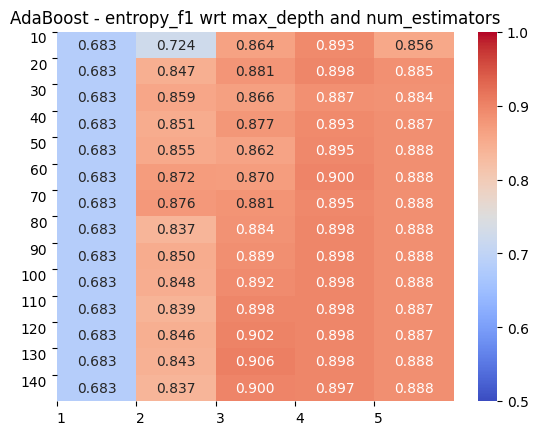

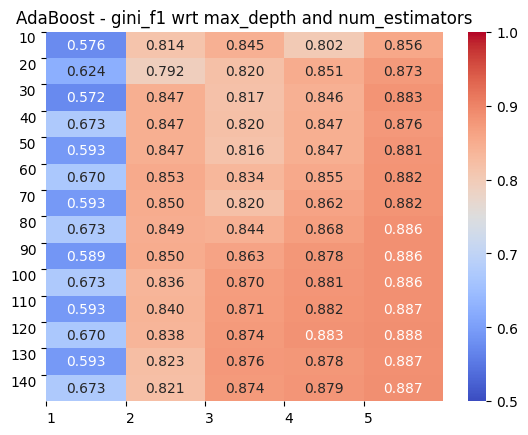

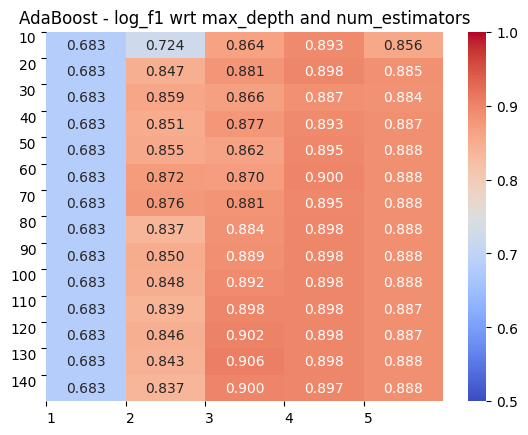

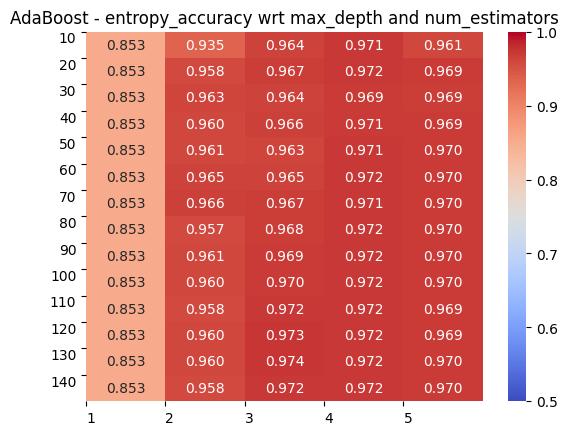

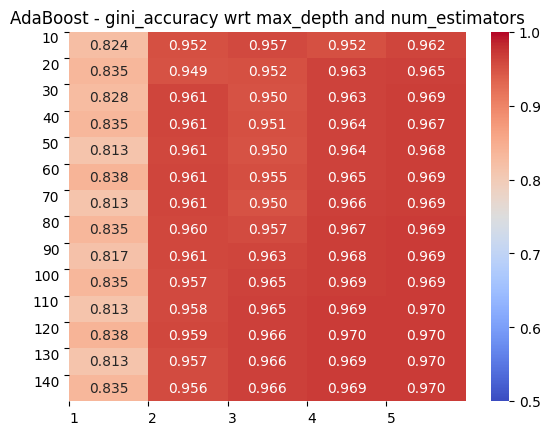

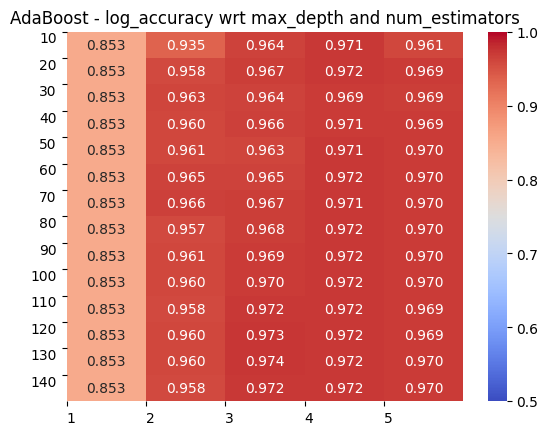

In [ ]:
plot_heatmap_ensemble(result_list, "f1", 5, 14, "AdaBoost")
plot_heatmap_ensemble(result_list, "accuracy", 5, 14, "AdaBoost")

In [ ]:
del abc_info

### Random Forest (RF)
Random Forest è un modello ensemble di Machine Learning di tipo bagging: è composto da molteplici predittori che vengono costruiti in modo indipendente l'uno dall'altro, dove, nel nostro caso, i predittori sono degli alberi decisionali. Questi ultimi vengono definiti a partire dal medesimo data set di partenza, per cui differiscono sulla base di quali feature vengono prese in considerazione a ogni iterazione per effettuare la migliore suddivisione del data set possibile.

Per stabilire il risultato complessivo del modello ensemble, si combinano gli output dei singoli decision tree presi tutti con lo stesso peso.

Per quanto riguarda l'utilizzo Random Forest, in modo del tutto analogo ad AdaBoost, sono stati presi in considerazione i seguenti tre parametri:
* **Max depth**: è l'altezza massima degli alberi decisionali che compongono Random Forest.
* **Estimators number**: è il numero di alberi decisionali che compongono il modello.
* **Criterion**: è una funzione che dà una misura sulla qualità degli split effettuati nello spazio dei punti per costruire ciascun albero decisionale.

La ricerca dei valori migliori degli iperparametri avviene allo stesso modo rispetto ad AdaBoost; sono stati riutilizzati anche i medesimi valori degli iperparametri.

SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: ('gini', 4, 50)
F1-score: 0.909940970292363
Accuracy: 0.9745744510704413

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


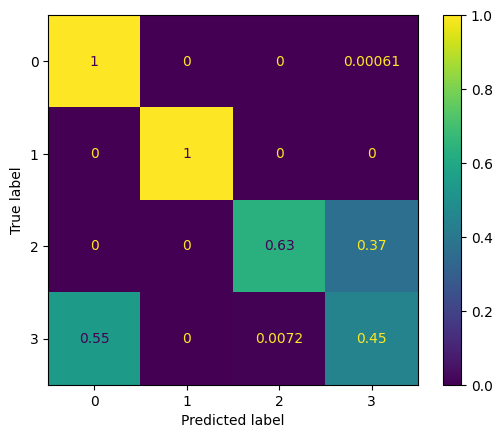


F1-score: 0.8079947432704384
Accuracy: 0.9343857918105575


In [ ]:
#Random Forest
lista_criteri=["gini", "entropy", "log_loss"]

rfc_info = best_classifier_info()

#faccio variare il valore degli iperparametri per applicare la cross validation e determinare è la configuraz migliore.
for n_tree in range(10,150,10):
  for criterio in lista_criteri:
    for max_deep in range(1,6):  #deve partire da 1 che è il minimo
      rfc = RandomForestClassifier(n_estimators=n_tree, criterion=criterio, max_depth=max_deep, max_features=None, random_state=0)
      rfc_info.update(rfc, (criterio, max_deep, n_tree))

best_index = rfc_info.get_best_index()
result_list = rfc_info.get_result_list()

rfc_info.print_info() #stampa di iperparametri, F1-score e accuracy della migliore iterazione della cross validation
rfc_best = RandomForestClassifier(n_estimators=best_index[2], criterion=best_index[0], max_depth=best_index[1], max_features=None, random_state=0)
#addestramento su training+validation set ed esecuzione su testing set del miglior predittore
dizionario_result["Random Forest"] = calcolo_metriche_classificazione(rfc_best)

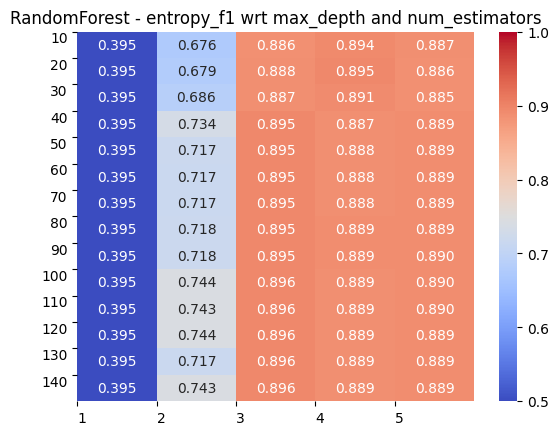

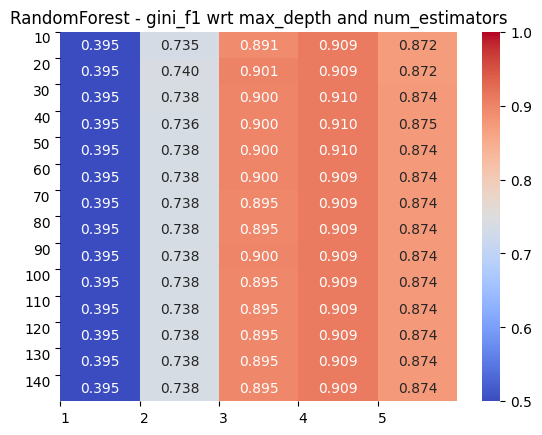

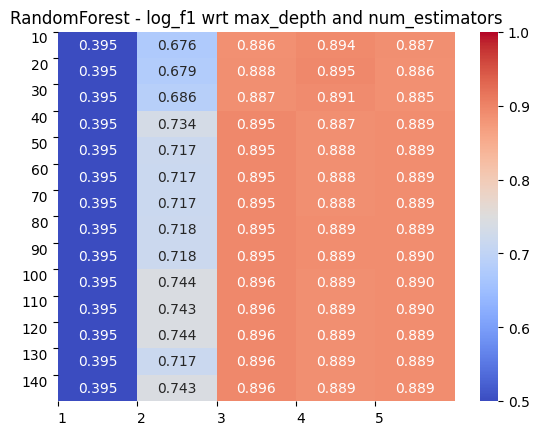

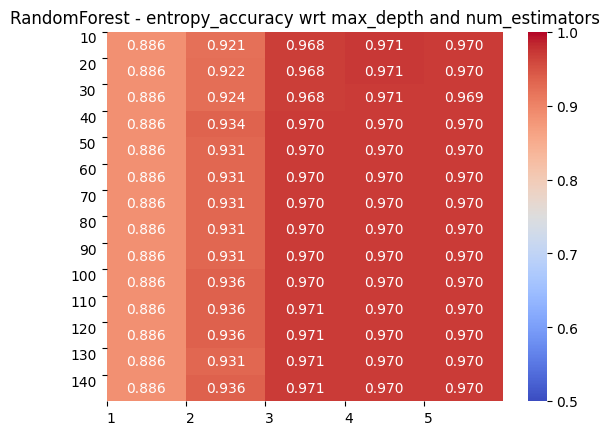

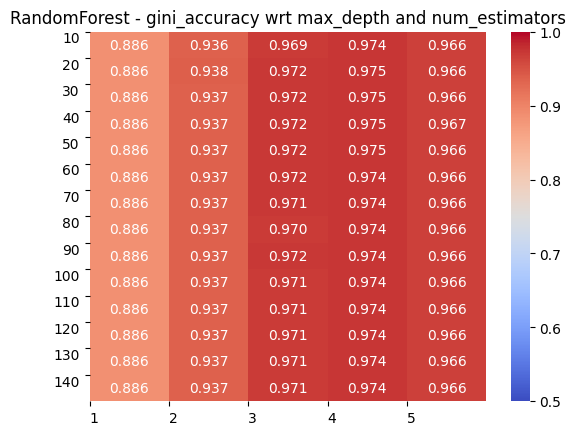

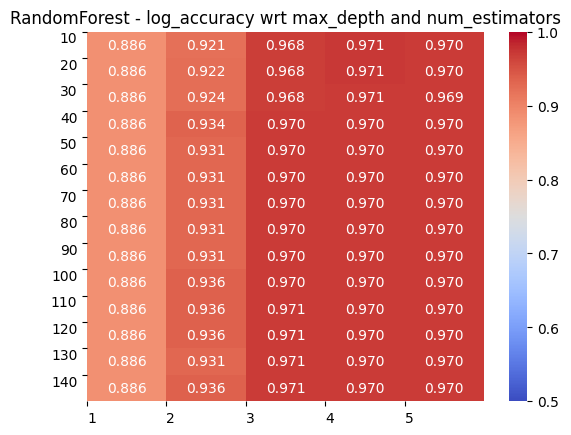

In [ ]:
plot_heatmap_ensemble(result_list, "f1", 5, 14, "RandomForest")
plot_heatmap_ensemble(result_list, "accuracy", 5, 14, "RandomForest")

In [ ]:
del rfc_info

### Support Vector Machine (SVM)
SVM è un modello di Machine Learning che si propone di trovare gli iperpiani di separazione migliori andando a minimizzare la seguente funzione:

$$ f(w,ξ) = \frac{1}{2}||w||^2 + C∑_{i=1}^n ξ_i $$
$$ where \space \space \space t_i(w^T \cdot x_i + w_0) \geq 1-ξ_i; \space \space \space ξ_i \geq 0 \space \space \space ∀i=1,...,n $$

dove:
* **$w$** dipende dalla direzione e dalla posizione di ciascun iperpiano di separazione;
* **$(x_i, t_i)$** sono i punti del training set col relativo target;
* **$ξ_i$** sono i costi da assegnare ai relativi punti $x_i$. Ciascuno di loro indica in quale misura non è stata rispettata la condizione $t_i(w^T \cdot x_i + w_0) \geq 1$, secondo cui dovrebbe esservi un margine tra il punto $x_i$ corrispondente e l'iperpiano di separazione (assumendo che $x_i$ si trovi nel lato giusto rispetto all'iperpiano stesso).

La libreria Sklearn, per risolvere il problema di minimizazione precedente, cerca di operare sul problema duale:
$$ \operatorname*{argmin}_{\alpha} \frac{1}{2}\alpha^TQ\alpha-e^T\alpha$$
con i seguenti vincoli:
 - $ y^T\alpha = 0$
 - $0 \leq\alpha_i \leq C \space \space \space \space \forall i=1,...,n$

In particolare:
* **$e$** è definito come un vettore con tutte le componenti poste al valore 1.
* **$Q$** è una matrice $n$ x $n$ semidefinita positiva, dove ogni sua componente é definita come: $Q_{i,j}=y_iy_j
\space \kappa(x_i,x_j)$

La predizione viene effettuata tramite la seguente funzione di decisione:

$$y(x)=\sum_{i \in SV} y_i\alpha_i \space \kappa(x,x_i)$$

dove SV è l'insieme di indici di tutti i vettori di supporto trovati durante l'addestramento del modello.



Per quanto riguarda l'utilizzo della SVM, sono stati presi in considerazione due parametri:
* **$C$**: è un coefficiente inversamente proporzionale alla regolarizzazione.
* **Kernel function**: è la funzione kernel utilizzata per dare una misura della distanza (o della somiglianza) tra il punto $x$ da valutare e un punto del training set.

La ricerca dei valori migliori degli iperparametri avviene in modo analogo al caso del Kernel Density Estimation, prendendo in esame le combinazioni di alcuni valori dei due parametri. In particolare:
* $C$ viene preso come una potenza di 2: $C = 2^{x}$, con $x$ che va da -3 a 3.
* Kernel function è una funzione kernel che può essere lineare, polinomiale di grado 2, polinomiale di grado 3, polinomiale di grado 4, gaussiana o sigmoidale.

SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: ('linear', 1, 0.25)
F1-score: 0.9623061891068554
Accuracy: 0.9866698654237209

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


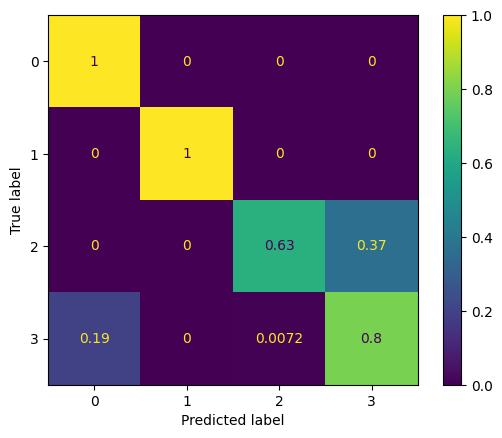


F1-score: 0.8730228989051161
Accuracy: 0.9590527873704983


In [ ]:
#SVM (Support Vector Machine)
kernels = [("linear",1), ("poly",2), ("poly",3), ("poly",4), ("rbf",1), ("sigmoid",1)]
list_c = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]

svc_info = best_classifier_info()

#faccio variare il valore degli iperparametri per applicare la cross validation e determinare è la configuraz migliore.
for c in list_c:
  for kernel in kernels:
      svc = SVC(C=c, kernel=kernel[0], degree=kernel[1], class_weight="balanced")
      svc_info.update(svc, (kernel[0], kernel[1], c))

best_index = svc_info.get_best_index()
result_list = svc_info.get_result_list()

svc_info.print_info() #stampa di iperparametri, F1-score e accuracy della migliore iterazione della cross validation
svc_best = SVC(C=best_index[2], kernel=best_index[0], degree=best_index[1], class_weight="balanced")
#addestramento su training+validation set ed esecuzione su testing set del miglior predittore
dizionario_result["SVM"] = calcolo_metriche_classificazione(svc_best)

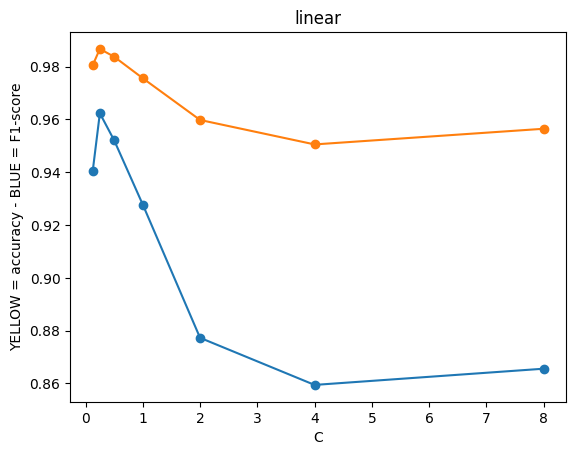

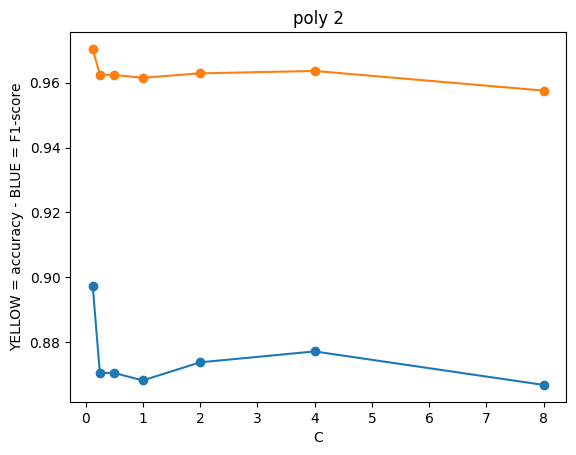

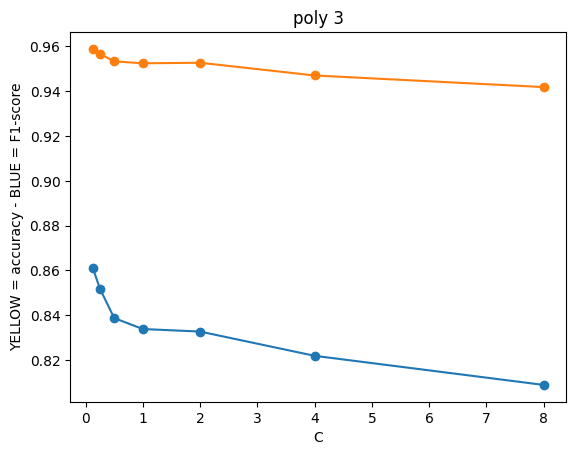

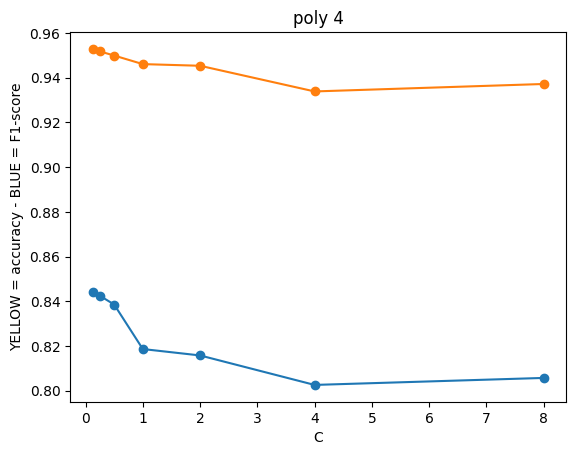

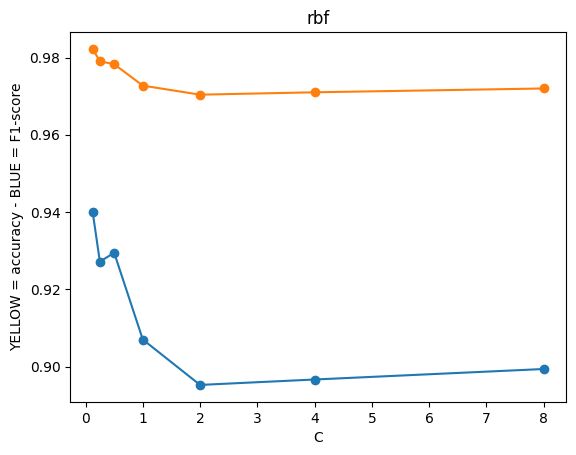

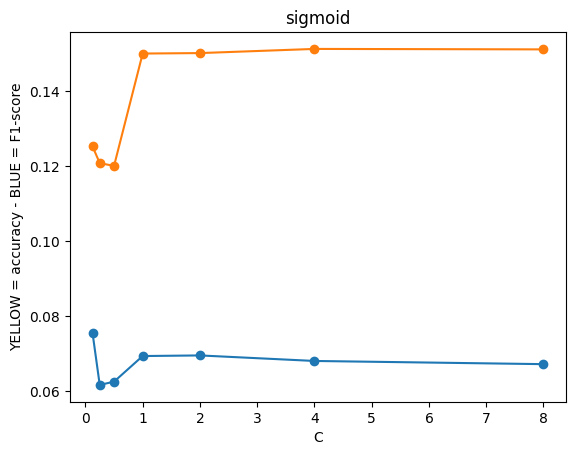

In [ ]:
plot_xy_graphics_svm(result_list, list_c)

In [ ]:
del svc_info

### Regressione Softmax
La regressione Softmax è un modello di Machine Learning che si propone di trovare gli iperpiani di separazione migliori andando a massimizzare la likelihood:

$$ L(W|X,T) = ∏_{i=1}^n ∏_{j=1}^k p(C_j|x_i)^{t_{ij}} = ∏_{i=1}^n ∏_{j=1}^k s(w_j^T \cdot \overline{x_i})^{t_{ij}} $$

dove:
* **$W$** è la matrice di tutti i parametri;
* **$X$** è la matrice delle feature di tutti gli elementi del training set;
* **$T$** è la matrice che mantiene i valori target di tutti gli elementi del training set nella notazione 1/k.

Per quanto riguarda l'utilizzo della regressione Softmax, sono stati presi in considerazione i seguenti parametri:
* **$C$**: è un coefficiente inversamente proporzionale alla regolarizzazione.
* **Solver+penalty**: è la modalità con cui viene eseguita l'ascesa del gradiente per massimizzare la likelihood dei parametri $w$ del classificatore; _penalty_ non è altro che il tipo di regolarizzazione applicata al modello.

La ricerca dei valori migliori degli iperparametri avviene ancora una volta in modo analogo al caso del Kernel Density Estimation, prendendo in esame le combinazioni di alcuni valori dei parametri. In particolare:
* $C$ viene preso come una potenza di 2: $C = 2^{x}$, con $x$ che va da -3 a 3.
* La coppia (solver, penalty) può assumere uno dei seguenti valori: (lbfgs, None), (lbfgs, l2), (sag, None), (sag, l2), (saga, None), (saga, l1), (saga, l2), dove l1 è la lasso regularization, mentre l2 è la ridge regularization.

SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: ('saga', 'l2', 1.0)
F1-score: 0.9377524021911674
Accuracy: 0.9786502006839246

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


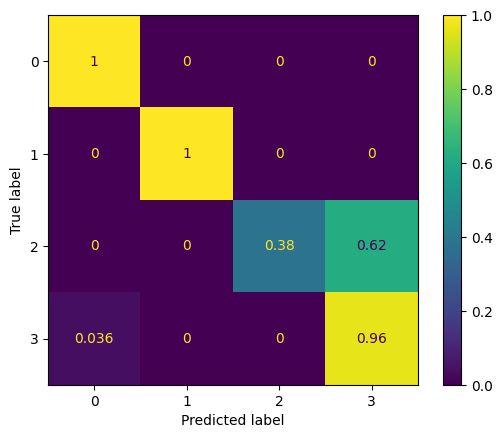


F1-score: 0.8203621361651698
Accuracy: 0.9516526887025161


In [ ]:
#Softmax
#parametri da variare
list_c = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
list_config = [{"solver":"lbfgs", "penalty":None},
               {"solver":"lbfgs", "penalty":"l2"},
               {"solver":"sag", "penalty":None},
               {"solver":"sag", "penalty":"l2"},
               {"solver":"saga", "penalty":None},
               {"solver":"saga", "penalty":"l1"},
               {"solver":"saga", "penalty":"l2"}]

#dichiarazione della struttura per trovare il classificatore softmax migliore
softmax_info = best_classifier_info()

#faccio variare il valore degli iperparametri per applicare la cross validation e determinare è la configuraz migliore.
for c in list_c:
  for conf in list_config:
    softmax = LogisticRegression(penalty=conf["penalty"], solver=conf["solver"], C=c, class_weight="balanced", multi_class="multinomial", verbose=0)
    softmax_info.update(softmax, (conf["solver"], conf["penalty"], c))
clear_output()

best_index = softmax_info.get_best_index()
result_list = softmax_info.get_result_list()

softmax_info.print_info() #stampa di iperparametri, F1-score e accuracy della migliore iterazione della cross validation
softmax_best = LogisticRegression(penalty=best_index[1], solver=best_index[0], C=best_index[2], class_weight="balanced", multi_class="multinomial", verbose=0)
#addestramento su training+validation set ed esecuzione su testing set del miglior predittore
dizionario_result["Softmax"] = calcolo_metriche_classificazione(softmax_best)

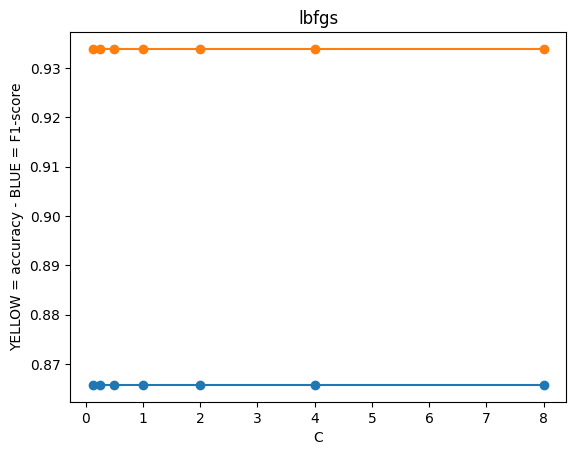

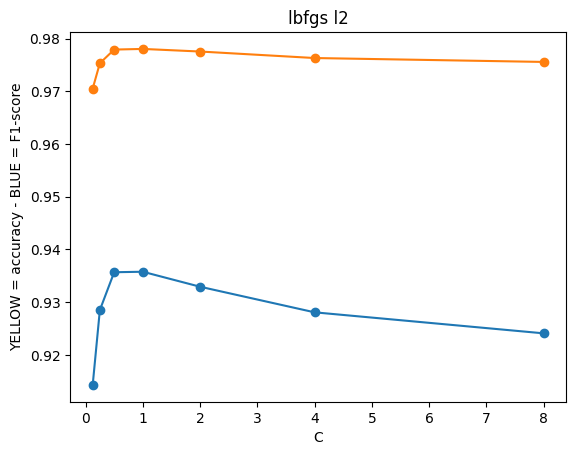

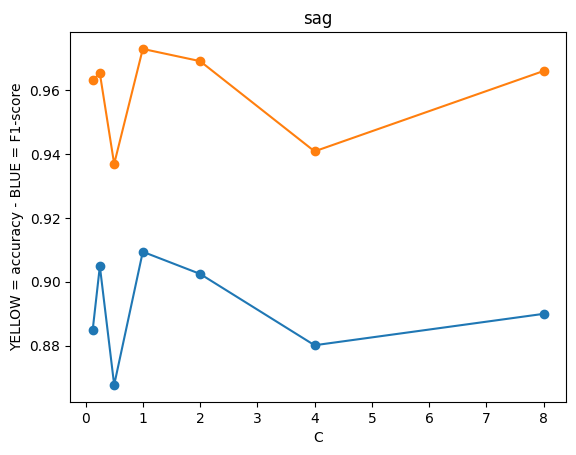

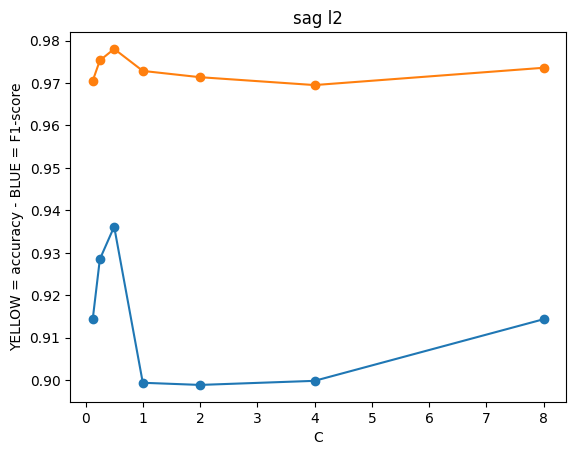

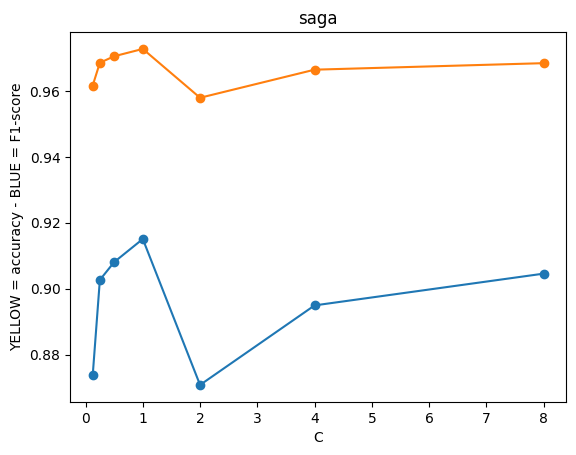

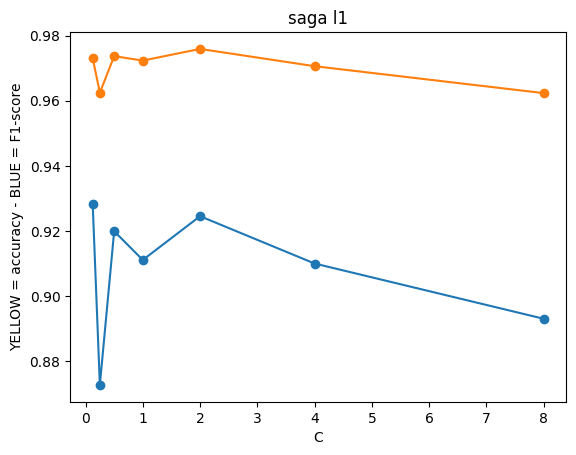

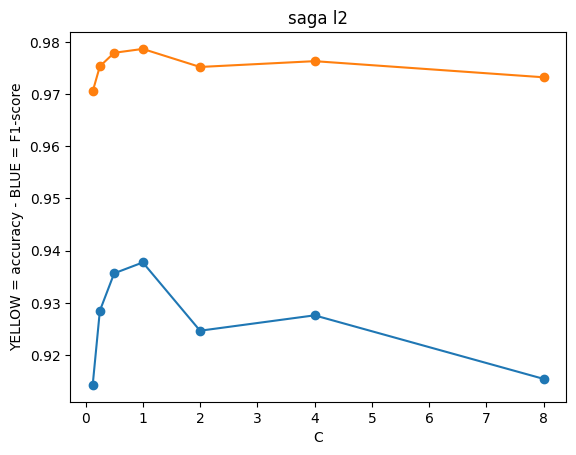

In [ ]:
plot_xy_graphics_svm(result_list, list_c)

In [ ]:
del softmax_info

### Multilayer Perceptron (MLP)
È una rete neurale composta da D layer totali, di cui i primi D-1 servono per modificare opportunamente la rappresentazione degli elementi, mentre l'ultimo server per effettuare la predizione vera e propria del target.

#### Primo layer
* $a_j^{(1)} = ∑_{i=1}^d w_{ji}^{(1)} x_i + w_{j0}^{(1)}$
* $z_j^{(1)} = h_1(a_j^{(1)}) \space$, dove $h_1()$ è una funzione non lineare (e.g. funzione segno, sigmoide, tangente iperbolica, ReLU).

#### Layer intermedi
* $a_j^{(k)} = ∑_{i=1}^{n_k} w_{ji}^{(k)} z_i^{(k-1)} + w_{j0}^{(k)}$
* $z_j^{(k)} = h_k(a_j^{(k)}) \space$, dove $h_k()$ è una funzione non lineare (e.g. funzione segno, sigmoide, tangente iperbolica, ReLU).

#### Ultimo layer
* $a_j^{(D)} = ∑_{i=1}^{n_D} w_{ji}^{(D)} z_i^{(D-1)} + w_{j0}^{(D)}$
* $y_j = s(a_j^{(D)})$

Per quanto riguarda l'utilizzo del Multilayer Perceptron, sono stati presi in considerazione i seguenti cinque parametri:
* **Activation function**: funzione non lineare che, per ogni layer, genera il valore $z_j^{(k)}$ a partire da $a_j^{(k)}$.
* **Configuration**: lista con un numero di entry pari al numero di layer intermedi della rete neurale; per ciascun layer, viene specificato il numero di neuroni che lo compongono.
* **Initial learning rate**: learning rate iniziale per l'esecuzione della discesa del gradiente (che ha lo scopo di trovare i parametri $w_{j,l}^{(k)}$ che minimizzino la funzione costo).
* **Beta1**: iperparametro associato alla variante Adam della discesa del gradiente.
* **Beta2**: altro iperparametro associato alla variante Adam della discesa del gradiente.

Per evitare di appesantire eccessivamente la computazione nella fase di cross validation, per il Multilayer Perceptron si è deciso di procedere secondo questo schema:
* Si suddividono i cinque parametri in due insiemi: [activation function, configuration] e [initial learning rate, beta1, beta2].
* Inizialmente si effettua un confronto tra più MLP andando a variare esclusivamente i parametri del primo insieme e tenendo fissi i parametri del secondo insieme ai rispettivi valori di default (initial learning rate = 0.001, beta1 = 0.9, beta2 = 0.999).
* Una volta trovati i valori migliori per activation fuction e configuration, si fissano questi ultimi e si fanno variare i valori dei parametri del secondo insieme.
* A questo punto, sono stati ottenuti dei valori degli iperparametri per cui il modello MLP funziona ragionevolmente bene. Non si tratta della soluzione ottima ma, in tal modo, si è evitato di istanziare, addestrare ed eseguire un numero di modelli pari alla combinazione dei valori di tutti e cinque gli iperparametri.

Comunque sia, i valori degli iperparametri che sono stati presi in considerazione sono riportati qui di seguito:
* Activation function può essere una funzione tra l'identità, la logistic function, la tangente iperbolica e la ReLU.
* Configuration viene impostato a uno di questi valori: [10] (un unico layer intermedio con 10 neuroni), [100] (un unico layer intermedio con 100 neuroni), [10,10] (due layer intermedi con 10 neuroni cadauno), [100,10] (due layer intermedi rispettivamente con 100 e 10 neuroni), [10,100] (due layer intermedi rispettivamente con 10 e 100 neuroni), [100,100] (due layer intermedi con 100 neuroni cadauno), [100,150,100] (tre layer intermedi rispettivamente con 100, 150 e 100 neuroni).
* Initial learning rate viene impostato a uno dei valori appartenenti all'insieme $\{0.01,0.005,0.001,0.0005,0.0001\}$.
* Beta1 viene impostato a uno dei valori appartenenti all'insieme $\{0.25,0.5,0.7,0.9,0.99,0.999\}$.
* Beta2 viene impostato a uno dei valori appartenenti all'insieme $\{0.25,0.5,0.99,0.999,0.9999\}$.

In [ ]:
#MLP
#ottenimento del modello MLP migliore confrontando solo le funzioni di attivazione, il numero di layer
#e il numero di neuroni in ogni layer
list_activation = ["identity", "logistic", "tanh", "relu"]
list_hidden_layer = [[10], [100], [10,10], [100,10], [10,100], [100,100] , [100,150,100]]

mlp_info_1 = best_classifier_info()

#faccio variare il valore degli iperparametri per applicare la cross validation e determinare è la configuraz migliore.
for activation in list_activation:
  for conf in list_hidden_layer:
    mlp_1 = MLPClassifier(activation=activation, hidden_layer_sizes=conf, random_state=0)
    mlp_info_1.update(mlp_1, (activation, conf))
clear_output()

best_index_1 = mlp_info_1.get_best_index()
result_list_1 = mlp_info_1.get_result_list()
mlp_info_1.print_info() #stampa di iperparametri, F1-score e accuracy della migliore iterazione della cross validation

SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: ('logistic', [10, 10])
F1-score: 0.958361921357438
Accuracy: 0.9859292008438626



SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: (0.001, 0.99, 0.99)
F1-score: 0.9629702528815629
Accuracy: 0.9871633879406859

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


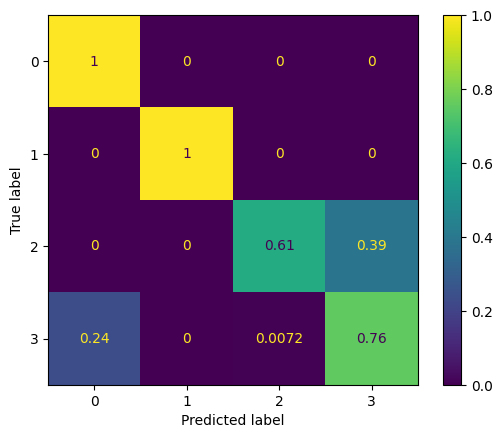


F1-score: 0.8606602681177639
Accuracy: 0.9546127281697089


In [ ]:
#ottenimento del modello MLP migliore partendo da quello trovato in precedenza e confrontando il learning rate
#iniziale e i due parametri beta1, beta2
list_learning_rate_init = [0.01,0.005,0.001,0.0005,0.0001]  #default = 0.001
list_beta1 = [0.25,0.5,0.7,0.9,0.99,0.999]                  #default = 0.9
list_beta2 = [0.25,0.5,0.99,0.999,0.9999]                   #default = 0.999

mlp_info_2 = best_classifier_info()

#faccio variare il valore degli iperparametri per applicare la cross validation e determinare è la configuraz migliore.
for learning_rate in list_learning_rate_init:
  for beta1 in list_beta1:
    for beta2 in list_beta2:
      mlp_2 = MLPClassifier(activation=best_index_1[0], hidden_layer_sizes=best_index_1[1], learning_rate_init=learning_rate, beta_1=beta1, beta_2=beta2, random_state=0)
      mlp_info_2.update(mlp_2, (learning_rate, beta1, beta2))
clear_output()

best_index_2 = mlp_info_2.get_best_index()
result_list_2 = mlp_info_2.get_result_list()

mlp_info_2.print_info()  #stampa di iperparametri, F1-score e accuracy della migliore iterazione della cross validation
mlp_best = MLPClassifier(activation=best_index_1[0], hidden_layer_sizes=best_index_1[1], learning_rate_init=best_index_2[0], beta_1=best_index_2[1], beta_2=best_index_2[2], random_state=0)
#addestramento su training+validation set ed esecuzione su testing set del miglior predittore
dizionario_result["MLP"] = calcolo_metriche_classificazione(mlp_best)

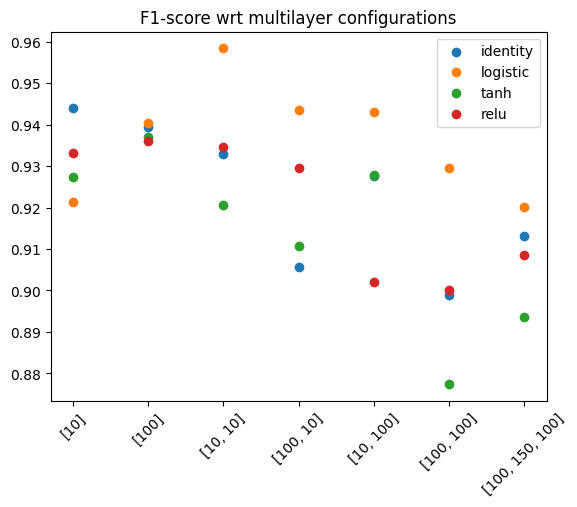

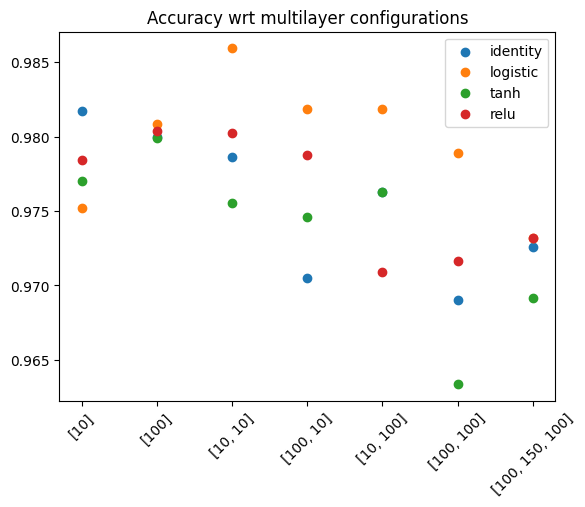

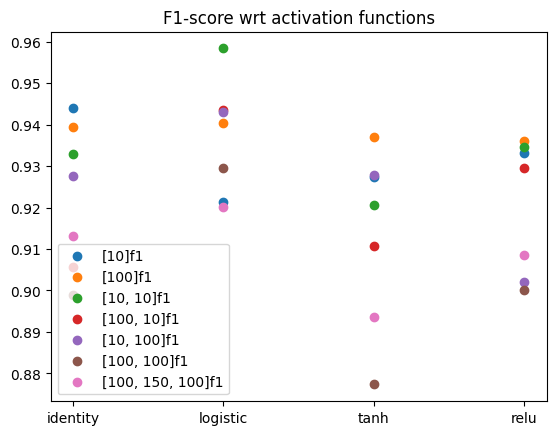

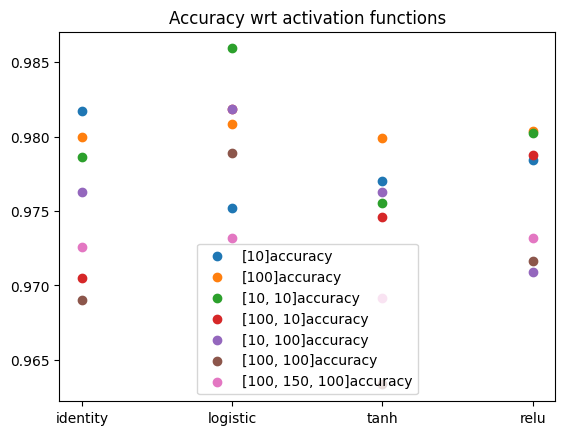

In [ ]:
plot_xy_graphics_mlp(result_list_1)

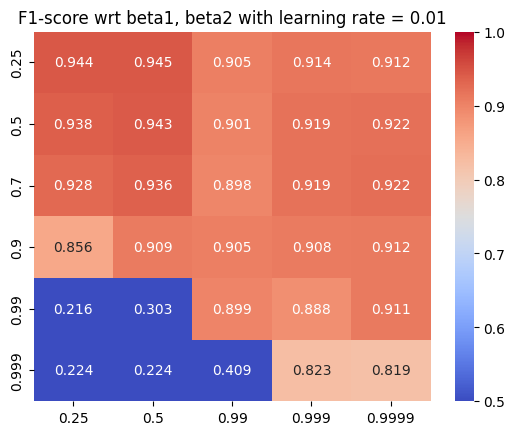

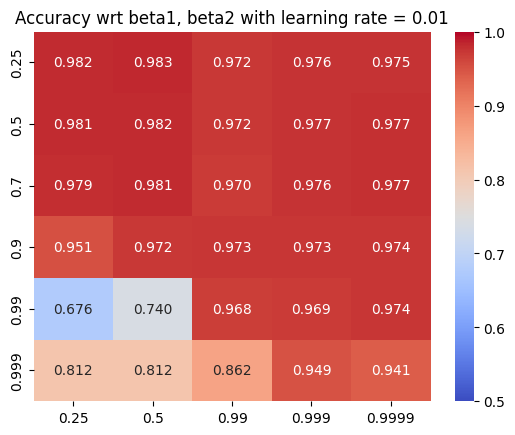

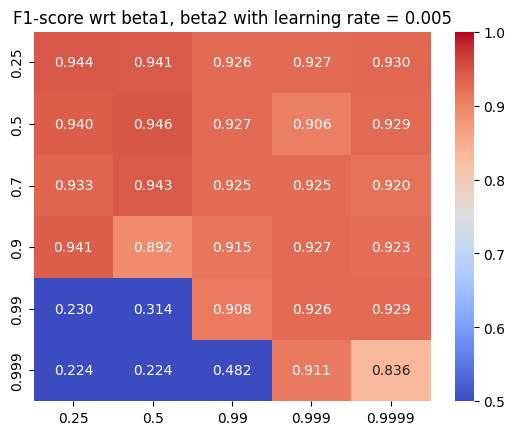

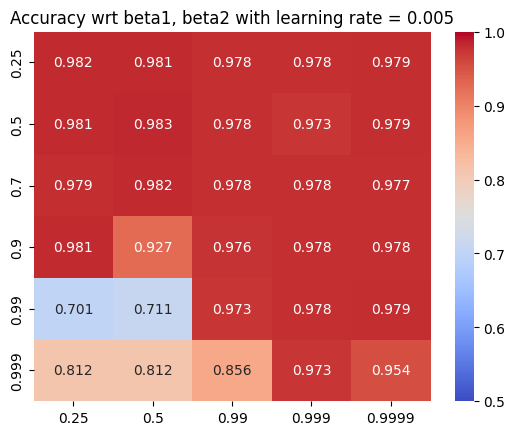

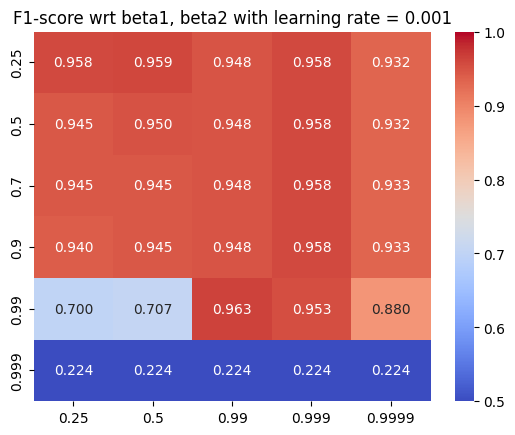

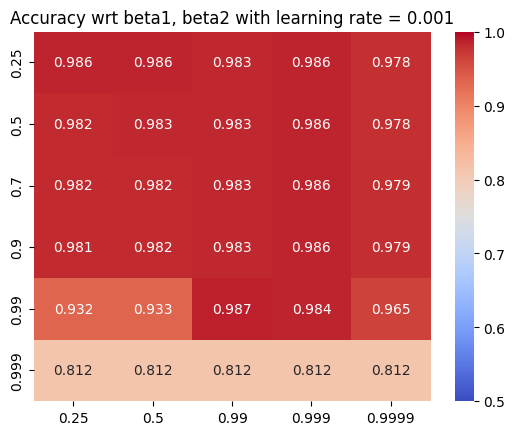

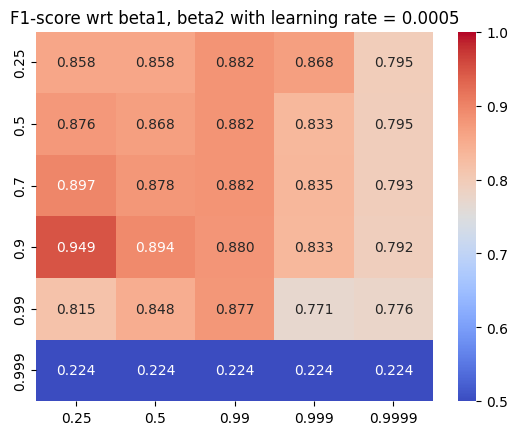

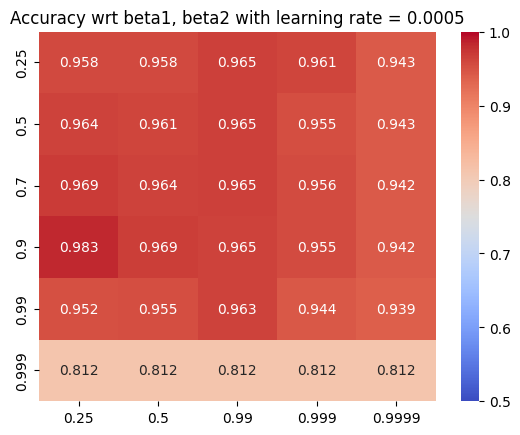

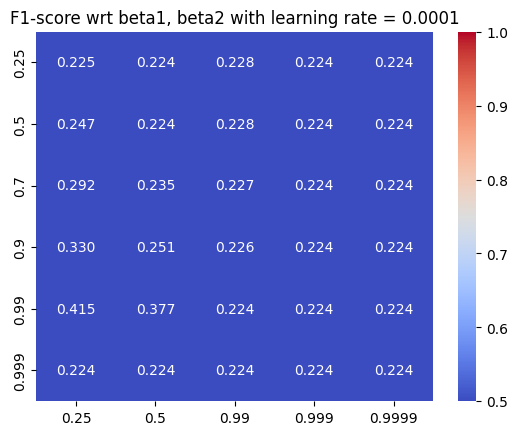

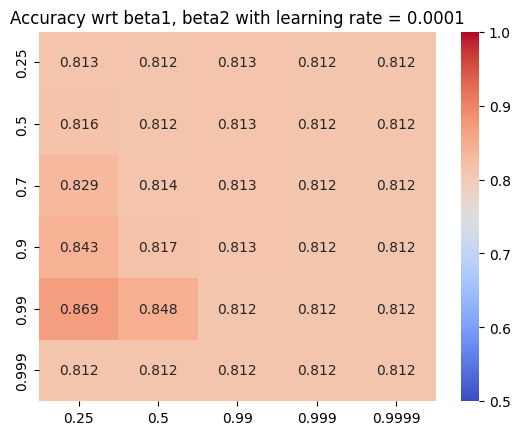

In [ ]:
plot_heatmap_multilayer(result_list_2)

In [ ]:
del mlp_info_1
del mlp_info_2

## Valutazione dei modelli di Machine Learning per la regressione

Gli algoritmi di Machine Learning di regressione che verranno confrontati sul data set "Occupancy_Estimation.csv" sono elencati qui di seguito:
* Regressione lineare
* Nadaraya-Watson

Per confrontare la bontà e le prestazioni di questi algoritmi, si ricorre anche qui alla matrice di confusione, all'F1-score e all'accuracy.

### Regressione lineare
La regressione lineare è un modello di Machine Learning che mira a calcolare la retta che approssima nel miglior modo possibile l'andamento dei punti all'interno dello spazio. \
L'output della sua predizione è dato da:

$$ y(x,w) = w^T \cdot x + w_0 = \sum_{j=1}^d w_jx_j +w_0 $$

I parametri $w$ migliori che determinano l'espressione della retta $y(x,w)$ vengono calcolati minimizzando una funzione costo che potrebbe essere siffatta:

$$ E(w) = \frac{1}{2} ∑_{i=1}^n \left(\sum_{j=1}^d w_jx_{ij} +w_0 - t_i \right)^2 $$

Questo algoritmo di Machine Learning, nella libreria sklearn, non prevede l'utilizzo di iperparametri interessanti. Di conseguenza, come nei casi di Gaussian Linear Discriminant Analysis, GDA e GNB, ci limiteremo ad addestrarlo sull'intero training+validation set e a valutare le sue prestazioni sulle predizioni degli elementi del testing set.

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


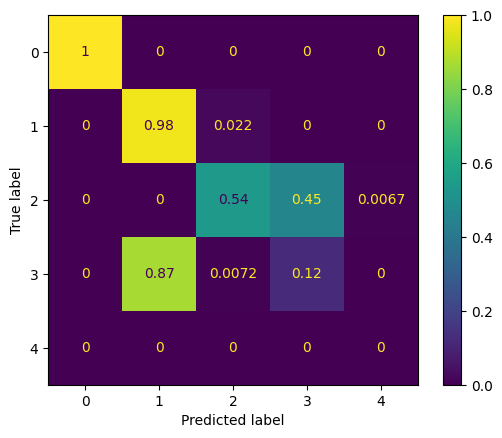


F1-score: 0.6543086587252658
Accuracy: 0.9047853971386285


In [ ]:
#Regressione lineare
#non ha iperparametri da stimare
linear_regression = LinearRegression()
linear_regression.fit(X_training, Y_training)
Y_pred = linear_regression.predict(X_testing)
dict_metrics = calcolo_stat(Y_testing,Y_pred)
dizionario_result["Linear Regression"] = {"f1":dict_metrics["test_f1_macro"], "accuracy":dict_metrics["test_accuracy"]}

print("METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET")
print("Confusion matrix:")
m = np.array(dict_metrics["confusion_matrix"])
confusion_matrix_plot(m)
print("")
print("F1-score:", dict_metrics["test_f1_macro"])
print("Accuracy:", dict_metrics["test_accuracy"])

### Nadaraya-Watson
Nadaraya-Watson è un modello di Machine Learning non parametrico che mira a calcolare il valor medio del target $t$ dato uno specifico elemento $x$ per effettuare la sua predizione. Il suo output è dato da:

$$ f(x) = E[t|x] = ∫p(t|x)t \space dt = ∫\frac{p(x,t)}{p(x)}t \space dt = \frac{∫p(x,t)t \space dt}{∫p(x,t)\space dt} = \frac{∫\frac{1}{n} ∑_{i=1}^n κ(x,x_i) κ(t,t_i) \space t \space dt}{∫\frac{1}{n} ∑_{i=1}^n κ(x,x_i) κ(t,t_i)\space dt} = \frac{∑_{i=1}^n κ(x,x_i) ∫κ(t,t_i) \space t \space dt}{∑_{i=1}^n κ(x,x_i) ∫κ(t,t_i)\space dt} = \frac{∑_{i=1}^n κ(x,x_i) \space t_i}{∑_{i=1}^n κ(x,x_i)} $$

Per quanto riguarda l'utilizzo di Nadaraya-Watson, si fissa la funzione kernel ad-hoc (date dalle funzioni di libreria _NadarayaWatsonHatMatrix_ e _KernelRegression_ di skfda) e si è fatto variare un unico iperparametro:
* **Bandwidth**: è un coefficiente che indica quanto deve essere ampia la funzione kernel; più è maggiore in modulo, più la funzione kernel è ampia.

Di nuovo, la ricerca dei valori migliori degli iperparametri avviene in modo analogo al caso del Kernel Densisty Estimation, prendendo in considerazione i seguenti valori per bandwidth:
$$b = 2^{x}, ∀x \in ℤ : -2 \le x \le 2 $$

SELEZIONE DEI PARAMETRI MIGLIORI PER IL CLASSIFICATORE
Best classifier parameters: 0.1
F1-score: 0.906245177216959
Accuracy: 0.9628493309266494

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


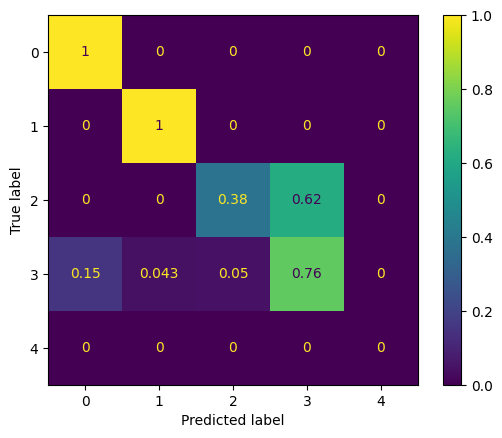


F1-score: 0.8094484435108389
Accuracy: 0.9373458312777504


In [ ]:
#Nadaraya-Watson
bandwidths = [10**x for x in range(-2,3,1)]

knw_info = best_classifier_info(isClassifier=False)

#faccio variare il valore dell'iperparametro b per applicare la cross validation e determinare è la configuraz migliore.
for b in bandwidths:
  kernel = NadarayaWatsonHatMatrix(bandwidth=b)
  knw = KernelRegression(kernel_estimator=kernel)
  knw_info.update(knw, (b))

best_index = knw_info.get_best_index()
result_list = knw_info.get_result_list()

knw_info.print_info() #stampa di b, F1-score e accuracy della migliore iterazione della cross validation
kernel_best = NadarayaWatsonHatMatrix(bandwidth=best_index)
knw_best = KernelRegression(kernel_estimator=kernel_best)

#addestramento su training+validation set ed esecuzione su testing set del miglior predittore
knw_best.fit(X_training.to_numpy(), Y_training.to_numpy())
Y_pred = knw_best.predict(X_testing.to_numpy())
dict_metrics = calcolo_stat(Y_testing, Y_pred)

print("METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET")
print("Confusion matrix:")
m = np.array(dict_metrics["confusion_matrix"])
confusion_matrix_plot(m)
print("")
print("F1-score:", dict_metrics["test_f1_macro"])
print("Accuracy:", dict_metrics["test_accuracy"])

dizionario_result["KNW"] = {"f1":dict_metrics["test_f1_macro"], "accuracy":dict_metrics["test_accuracy"]}

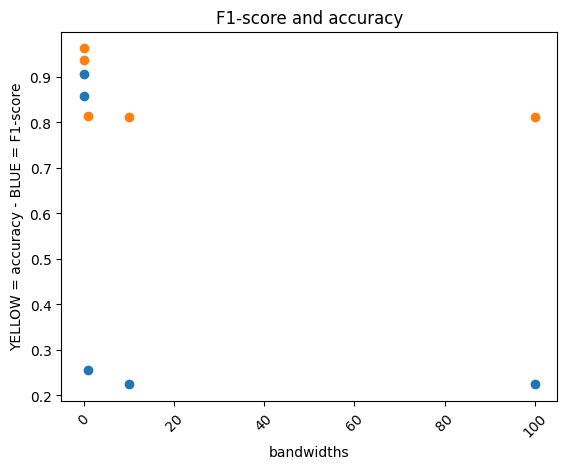

In [ ]:
plot_data = [[],[]]

for item in result_list:
  plot_data[0].append(item[1]["f1"])
  plot_data[1].append(item[1]["accuracy"])

plot_xy_graphic_kde(bandwidths, plot_data, "bandwidths")

In [ ]:
del knw_info

## Confronto tra i modelli
Arrivati a questo punto, abbiamo confrontato le metriche prestazionali dei vari modelli di Machine Learning per stabilire quali sono i migliori per il data set in esame.

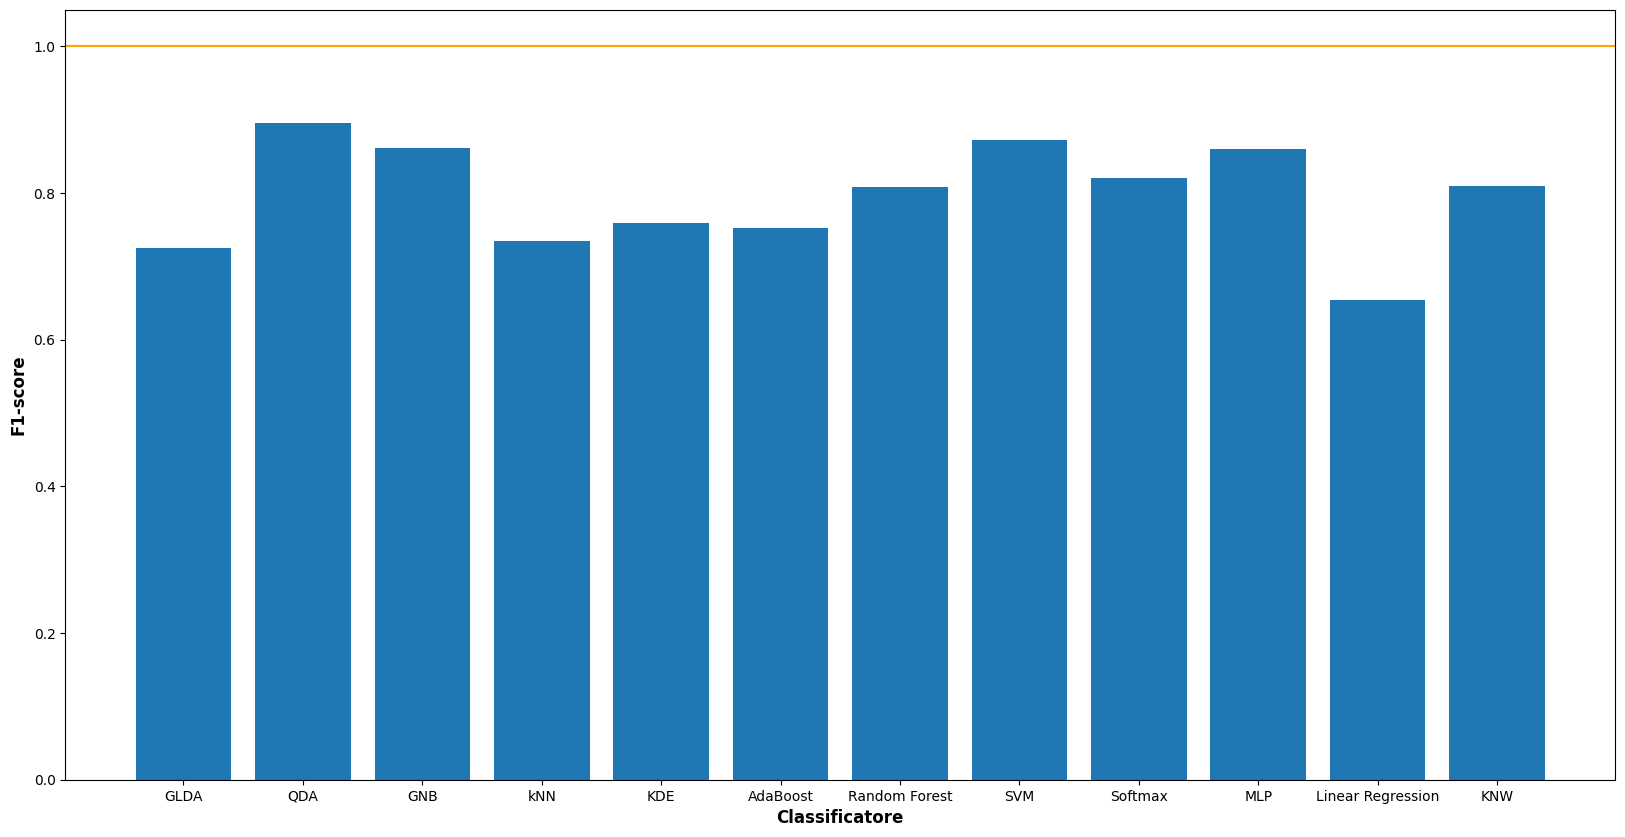

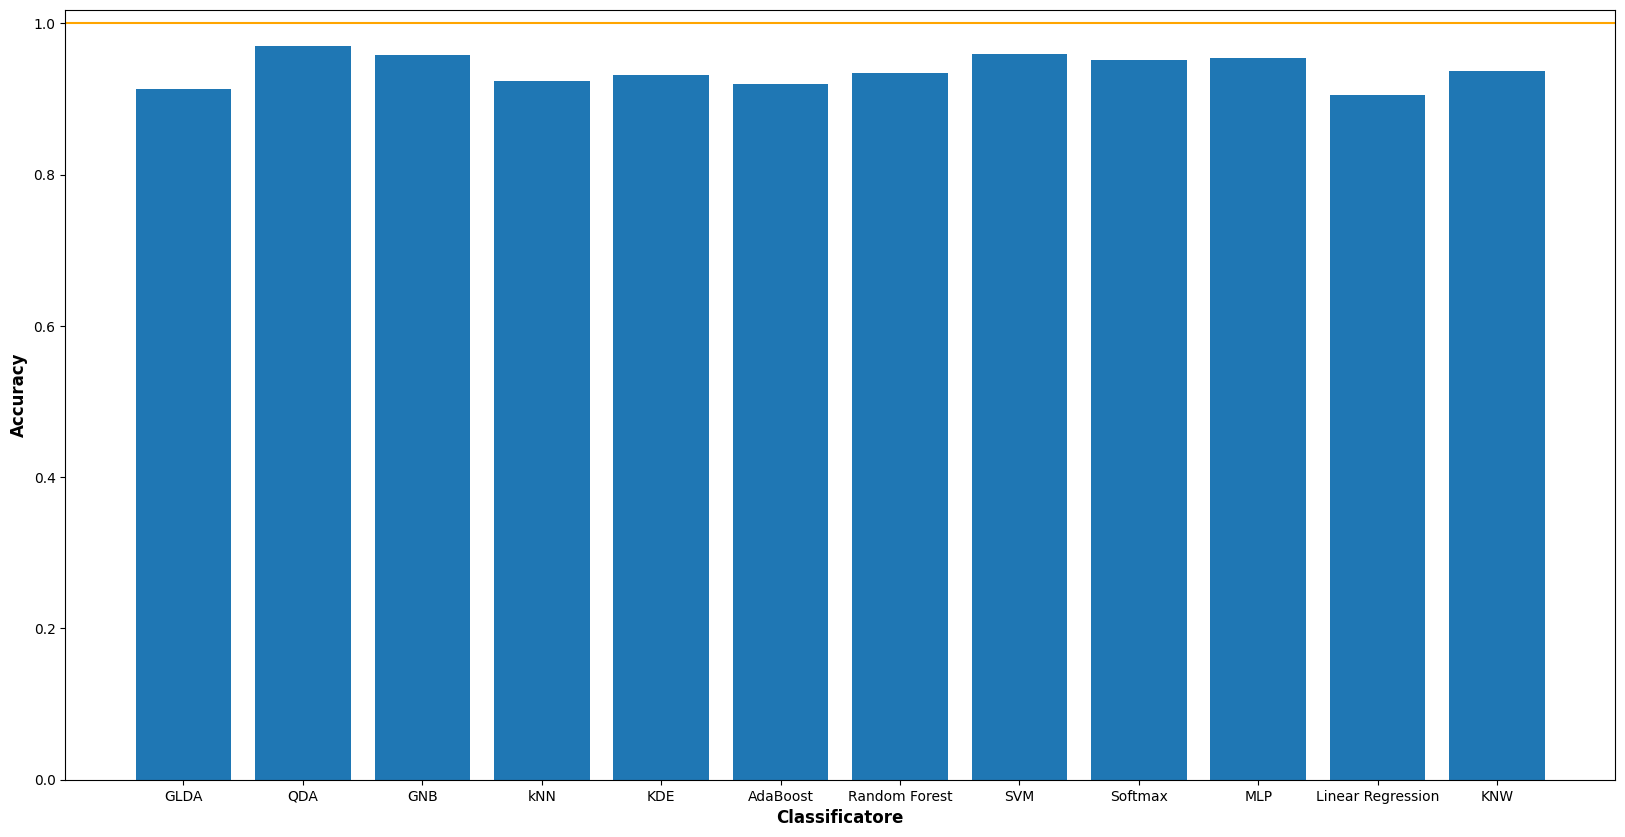

In [ ]:
data_result = pd.DataFrame(dizionario_result)
data_result = data_result.T   #data_result.T = matrice trasposta di data_result

#plot F1-score dei 12 modelli analizzati
plt.figure(figsize=(20,10))
plt.bar(x=data_result.index, height=data_result["f1"])
plt.axhline(y=1, color='orange')
plt.xlabel('Classificatore', fontsize="large", fontweight="bold")
plt.ylabel('F1-score', fontsize="large", fontweight="bold")
plt.show()

#plot accuracy dei 12 modelli analizzati
plt.figure(figsize=(20,10))
plt.bar(x=data_result.index, height=data_result["accuracy"])
plt.axhline(y=1, color='orange')
plt.xlabel('Classificatore', fontsize="large", fontweight="bold")
plt.ylabel('Accuracy', fontsize="large", fontweight="bold")
plt.show()

In base ai risultati ottenuti durante le simulazioni e ai grafici riportati qui sopra, è emerso che i migliori quattro predittori sono:
* **Multilayer Perceptron**, con F1-score = 0.8607 e accuracy = 0.9546;
* **Gaussian Naive Bayes**, con F1-score = 0.8620 e accuracy = 0.9576;
* **Support Vector Machine**, con F1-score = 0.8730 e accuracy = 0.9591;
* **Quadratic Discriminant Analysis**, con F1-score = 0.8950 e accuracy = 0.9694

Nelle prossime sezioni, ci concentreremo per lo più sul comportamento di questi quattro modelli (coi valori degli iperparametri già ricavati durante il processo di cross validation).

## Under-sampling
Poiché oltre l'80% degli elementi del data set appartiene alla classe 0, può essere ragionevole applicare un under-sampling al data set in modo tale che tutte e quattro le classi contengano lo stesso numero di elementi (i.e. il numero di elementi della classe originariamente meno numerosa). In tal modo, sarà possibile confrontare le prestazioni dei quattro modelli di Machine Learning in esame (QDA, GNB, SVM, MLP) tra il caso senza under-sampling e il caso con under-sampling.

Total number of elements: 8102
Class 0 - (number of elements, number of columns): (6582, 17)
Class 1 - (number of elements, number of columns): (367, 17)
Class 2 - (number of elements, number of columns): (598, 17)
Class 3 - (number of elements, number of columns): (555, 17)


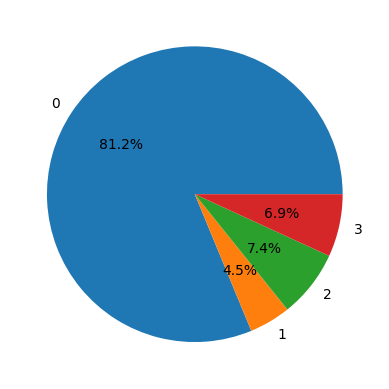


Total number of elements: 1468
Class 0 - (number of elements, number of columns): (367, 17)
Class 1 - (number of elements, number of columns): (367, 17)
Class 2 - (number of elements, number of columns): (367, 17)
Class 3 - (number of elements, number of columns): (367, 17)


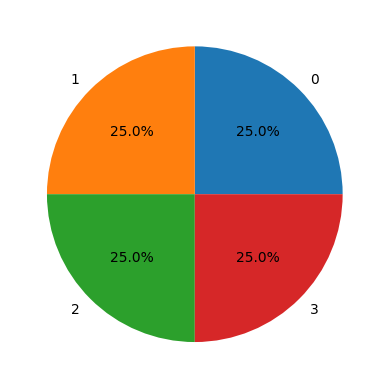

[367, 367, 367, 367]

In [ ]:
#under-sampling
vetDim = check_bilanciamento_classi(trainingValidationSet)
dimensione_minima = np.min(vetDim)  #dimensione_minima = num elementi appartenenti alla classe più piccola
print("")

#df_underX = porzione del nuovo data set (ottenuto a seguito dell'under-sampling) contenente gli elementi della classe X
df_under0 = trainingValidationSet[trainingValidationSet['Room_Occupancy_Count']==0].sample(n=dimensione_minima, random_state=0)
df_under1 = trainingValidationSet[trainingValidationSet['Room_Occupancy_Count']==1].sample(n=dimensione_minima, random_state=0)
df_under2 = trainingValidationSet[trainingValidationSet['Room_Occupancy_Count']==2].sample(n=dimensione_minima, random_state=0)
df_under3 = trainingValidationSet[trainingValidationSet['Room_Occupancy_Count']==3].sample(n=dimensione_minima, random_state=0)
df_under = pd.concat([df_under0, df_under1, df_under2, df_under3])

check_bilanciamento_classi(df_under)

In [ ]:
#ottenimento di: feature di trainingValidationSet_under; target di trainingValidationSet_under
X_training_under = df_under.iloc[:,:-1]
Y_training_under = df_under.iloc[:,-1]

### Under-sampling su QDA

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET (CON UNDER-SAMPLING)
Confusion matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:954: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


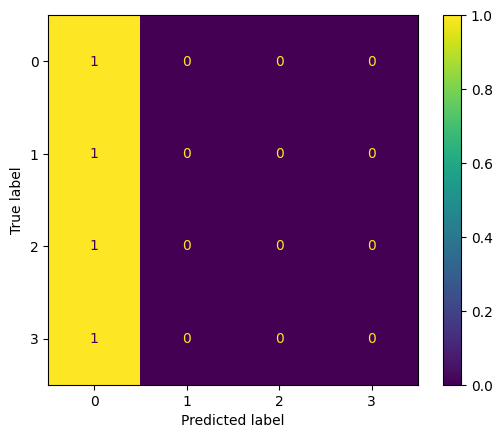


F1-score: 0.22406751973863326
Accuracy: 0.8120374938332511

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


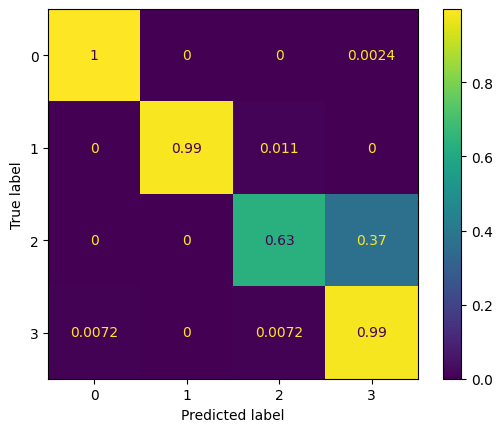


F1-score: 0.8950391293015307
Accuracy: 0.9694129255056734


{'f1': 0.8950391293015307, 'accuracy': 0.9694129255056734}

In [ ]:
#QDA con under-sampling (confrontato col caso senza under-sampling)
QDA = QuadraticDiscriminantAnalysis()
calcolo_metriche_classificazione(QDA, X=X_training_under, Y=Y_training_under, X_test=X_testing, Y_test=Y_testing)
print("")
calcolo_metriche_classificazione(QDA)

È possibile notare che il modello QDA, con l'under-sampling, prende una brutta piega: inizia a classificare tutti gli elementi del testing set come appartenenti alla classe 0. Evidentemente, ha bisogno di un numero sufficientemente elevato di dati nel training set per poter funzionare correttamente.

### Under-sampling su GNB

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET (CON UNDER-SAMPLING)
Confusion matrix:


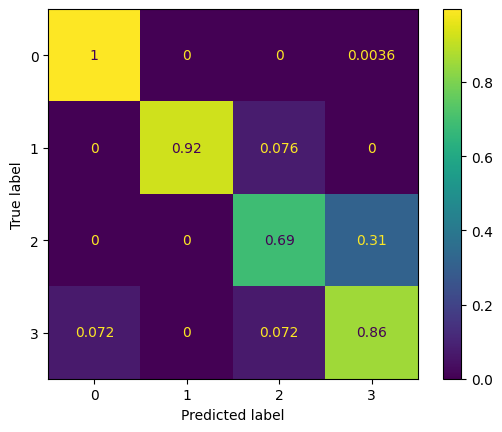


F1-score: 0.87095847083229
Accuracy: 0.9605328071040947

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


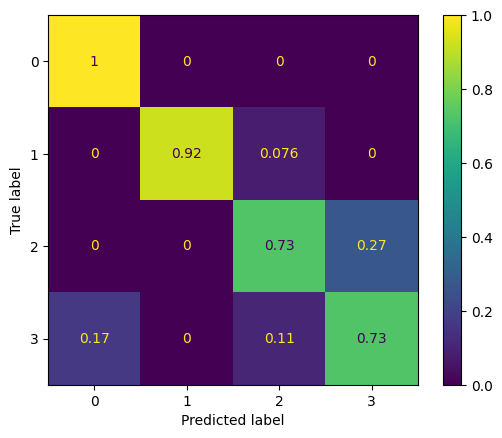


F1-score: 0.8620439348074946
Accuracy: 0.9575727676369018


{'f1': 0.8620439348074946, 'accuracy': 0.9575727676369018}

In [ ]:
#GNB con under-sampling (confrontato col caso senza under-sampling)
GNB = GaussianNB()
calcolo_metriche_classificazione(GNB, X=X_training_under, Y=Y_training_under, X_test=X_testing, Y_test=Y_testing)
print("")
calcolo_metriche_classificazione(GNB)

Il modello GNB sperimenta un leggero miglioramento con l'under-sampling: infatti, sia l'F1-score che l'accuracy aumentano leggermente e ciò, come si può vedere dalle matrici di confusione, è giustificato dal fatto che ora il modello è in grado di predire meglio gli elementi realmente appartenenti alla classe 3.

### Under-sampling su SVM

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET (CON UNDER-SAMPLING)
Confusion matrix:


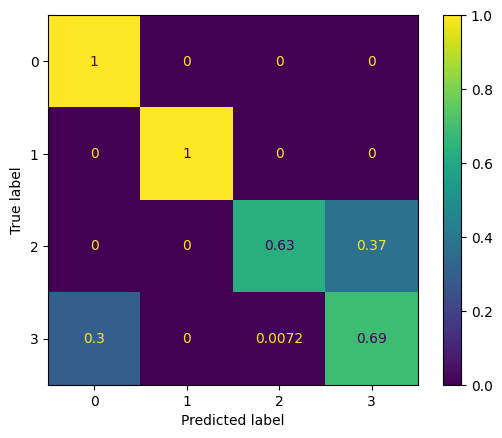


F1-score: 0.8536358181761502
Accuracy: 0.9511593487913172

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


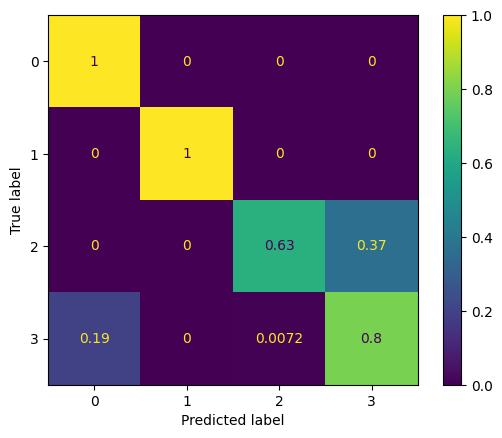


F1-score: 0.8730228989051161
Accuracy: 0.9590527873704983


{'f1': 0.8730228989051161, 'accuracy': 0.9590527873704983}

In [ ]:
#SVM con under-sampling (confrontato col caso senza under-sampling)
SVM = SVC(C=0.25, kernel="linear", degree=1, class_weight="balanced")
calcolo_metriche_classificazione(SVM, X=X_training_under, Y=Y_training_under, X_test=X_testing, Y_test=Y_testing)
print("")
calcolo_metriche_classificazione(SVM)

Il modello SVM, invece, sperimenta un leggero peggioramento con l'under-sampling: infatti, sia l'F1-score che l'accuracy diminuiscono leggermente ed effettivamente si ha una maggiore difficoltà nel riconoscere gli elementi realmente appartenenti alla classe 3.

### Under-sampling su MLP

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET (CON UNDER-SAMPLING)
Confusion matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


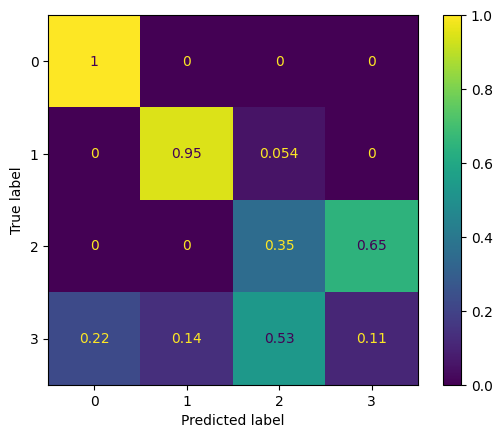


F1-score: 0.5912168490775633
Accuracy: 0.8885051800690675

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


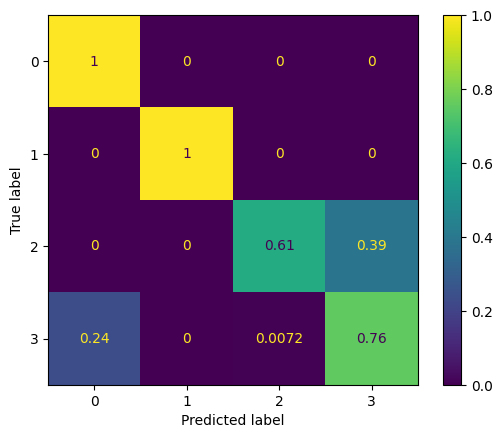


F1-score: 0.8606602681177639
Accuracy: 0.9546127281697089


{'f1': 0.8606602681177639, 'accuracy': 0.9546127281697089}

In [ ]:
#MLP con under-sampling (confrontato col caso senza under-sampling)
MLP = MLPClassifier(activation="logistic", hidden_layer_sizes=[10,10], learning_rate_init=0.001, beta_1=0.99, beta_2=0.99, random_state=0)
calcolo_metriche_classificazione(MLP, X=X_training_under, Y=Y_training_under, X_test=X_testing, Y_test=Y_testing)
print("")
calcolo_metriche_classificazione(MLP)

Il modello MLP, infine, sperimenta un peggioramento significativo con l'under-sampling: soprattutto l'F1-score decresce vertiginosamente e in effetti si ha una grossa difficoltà nel riconoscere gli elementi realmente appartenenti alle classi 2 e 3.

In definitiva, sembrerebbe che, tra i quattro modelli sotto esame, l'under-sampling sia conveniente da applicare solo al Gaussian Naive Bayes.

## Feature selection
Poiché il data set è composto da poche feature (16), si è preferito non applicare alcun meccanismo che riducesse la dimensionalità del problema. Tuttavia, a seguito dell'analisi effettuata su tutte e 16 le feature, può essere interessante verificare il comportamento dei quattro modelli sotto esame nel momento in cui la dimensionalità del problema si riduce. A tal proposito, è stata sfruttata la feature selection, che consiste nel mantenere solo un certo numero k di feature all'interno del data set, scartando tutte le altre. Il meccanismo di feature selection utilizzato nel progetto è quello implementato nella funzione SelectKBest() della libreria _sklearn_, che fa uso di un test d'ipotesi basato sulla correlazione tra ciascuna feature e il target e tra le feature tra di loro.

Per analizzare in modo esaustivo il comportamento dei predittori con la feature selection, si è deciso di far variare il numero k di feature da mantenere da 1 a 16.

### Funzioni ausiliarie

In [ ]:
#feature_selection è una funzione che valuta il classificatore dato in input su 16 data set differenti,
#ciascuno dei quali è composto da un numero differente di feature (da 1 a 16); la selezione delle feature
#da mantenere a ogni iterazione avviene sulla base di meccanismi implementati nella funzione SelectKBest()
#della libreria sklearn che si basano sulla correlazione tra ciascuna feature e il target e tra le feature
#tra di loro.
def feature_selection(classificatore, X, Y, undersampling=False):
  max = {"f1":-1, "accuracy":-1}
  l=[]
  best_index = -1
  best_feature=[]
  for k in range(1,17):
    X_new = SelectKBest(chi2, k=k).set_output(transform="pandas").fit_transform(X,Y)
    classificatore.fit(X_new, Y)
    Y_pred = classificatore.predict(X_testing[list(X_new.columns)])

    f1 = f1_score(y_true=Y_testing, y_pred=Y_pred, average="macro")
    accuracy = accuracy_score(y_true=Y_testing, y_pred=Y_pred)
    l.append([f1,accuracy])

    #check su se le prestazioni sono le migliori per il numero di feature corrente
    if max["f1"] < f1 or (max["f1"]==f1 and max["accuracy"]<accuracy):
      max["f1"] = f1
      max["accuracy"] = accuracy
      best_index = k
      best_feature = X_new.columns.values
  clear_output()
  if undersampling == True:
    print("CASO CON UNDERSAMPLING")
  else:
    print("CASO SENZA UNDERSAMPLING")
  print("Best number of features:", best_index)
  print("F1-score:", max["f1"])
  print("Accuracy:", max["accuracy"])
  print("Feature che rimangono:", best_feature)
  print("")

  return l

In [ ]:
#plot grafici per la feature selection (fs)
def plot_xy_graphics_fs(l1, l2):
  #plot grafico 1 (caso senza under-sampling)
  plt.plot(l1, marker='o')  #marker='o' disegna i puntini sul grafico.
  plt.title("F1-score and accuracy wrt features num")
  plt.xlabel("k")
  ticks_position = [x for x in range(0,16)]
  ticks_label = [t+1 for t in ticks_position]
  plt.xticks(ticks_position, ticks_label)
  plt.ylabel("YELLOW = accuracy - BLUE = F1-score")
  plt.show()

  #plot grafico 2 (caso con under-sampling)
  plt.plot(l2, marker='o')
  plt.title("F1-score and accuracy wrt features num (with under-sampling)")
  plt.xlabel("k")
  ticks_position = [x for x in range(0,16)]
  ticks_label = [t+1 for t in ticks_position]
  plt.xticks(ticks_position, ticks_label)
  plt.ylabel("YELLOW = accuracy - BLUE = F1-score")
  plt.show()

In [ ]:
def migiori_freature(X,Y,k):
    X_new = SelectKBest(chi2, k=k).set_output(transform="pandas").fit_transform(X,Y)
    v=X_new.columns.values
    print("per K:",k)
    print("i migliori componenti sono: ")
    print(v)

### Feature selection su QDA

In [ ]:
QDA = QuadraticDiscriminantAnalysis()
result_list = feature_selection(QDA, X_training, Y_training)

CASO SENZA UNDERSAMPLING
Best number of features: 16
F1-score: 0.8950391293015307
Accuracy: 0.9694129255056734
Feature che rimangono: ['S1_Temp' 'S2_Temp' 'S3_Temp' 'S4_Temp' 'S1_Light' 'S2_Light' 'S3_Light'
 'S4_Light' 'S1_Sound' 'S2_Sound' 'S3_Sound' 'S4_Sound' 'S5_CO2'
 'S5_CO2_Slope' 'S6_PIR' 'S7_PIR']



In [ ]:
result_list_undersampling = feature_selection(QDA, X_training_under, Y_training_under, True)

CASO CON UNDERSAMPLING
Best number of features: 1
F1-score: 0.22406751973863326
Accuracy: 0.8120374938332511
Feature che rimangono: ['S7_PIR']



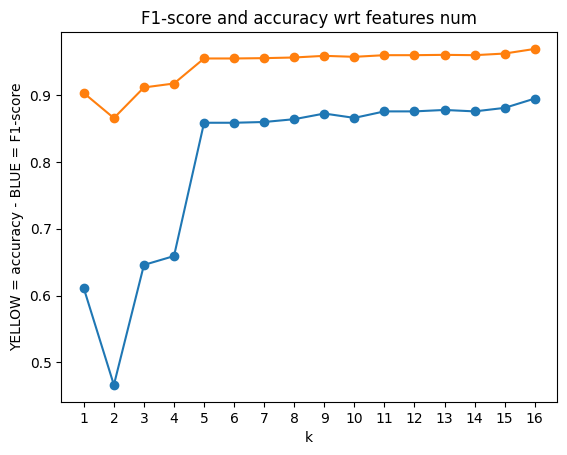

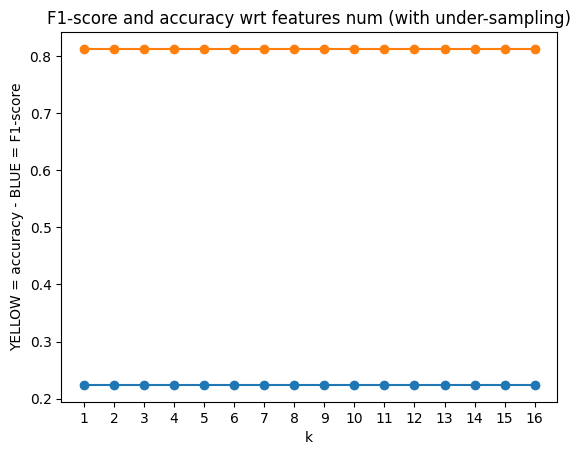

In [ ]:
plot_xy_graphics_fs(result_list, result_list_undersampling)

È possibile osservare che:
* Senza l'applicazione dell'under-sampling, tendenzialmente, QDA si comporta meglio all'aumentare del numero di feature. Tuttavia, sembrerebbe che, già per K=5, sia l'F1-score che l'accuracy raggiungano il valore di regime: di conseguenza, se si vuole ridurre il numero delle feature per rendere più efficienti l'addestramento del modello e le predizioni, basta lasciare almeno le 5 feature calcolate con la funzione SelectKBest senza che la qualità del modello degradi significativamente.
* Con l'applicazione dell'under-sampling, come avevamo già visto in precedenza, le prestazioni di QDA peggiorano vertiginosamente per effetto del fatto che il modello inizia a predire esclusivamente la classe 0.

In [ ]:
migiori_freature(X_training,Y_training,5)

per K: 5
i migliori componenti sono: 
['S1_Light' 'S2_Light' 'S3_Light' 'S6_PIR' 'S7_PIR']


### Feature selection su GNB

In [ ]:
GNB = GaussianNB()
result_list = feature_selection(GNB, X_training, Y_training)

CASO SENZA UNDERSAMPLING
Best number of features: 9
F1-score: 0.8757519167763992
Accuracy: 0.9610261470152935
Feature che rimangono: ['S1_Light' 'S2_Light' 'S3_Light' 'S1_Sound' 'S2_Sound' 'S3_Sound'
 'S5_CO2' 'S6_PIR' 'S7_PIR']



In [ ]:
result_list_undersampling = feature_selection(GNB, X_training_under, Y_training_under, True)

CASO CON UNDERSAMPLING
Best number of features: 7
F1-score: 0.8741076541643125
Accuracy: 0.9600394671928959
Feature che rimangono: ['S1_Light' 'S2_Light' 'S3_Light' 'S3_Sound' 'S5_CO2' 'S6_PIR' 'S7_PIR']



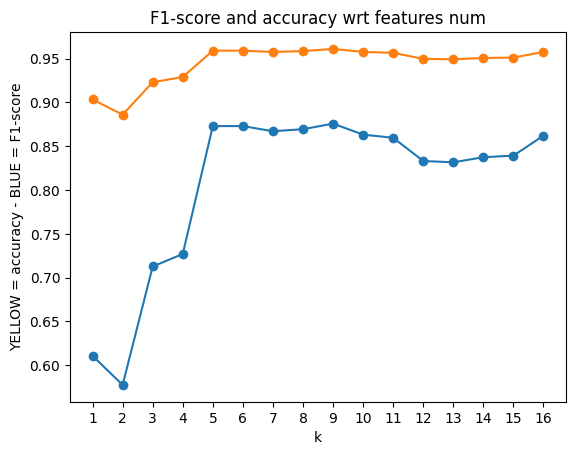

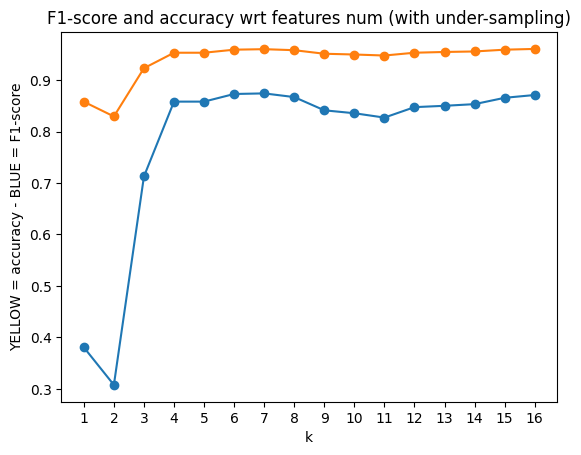

In [ ]:
plot_xy_graphics_fs(result_list, result_list_undersampling)

È possibile osservare che:
* Senza l'applicazione dell'under-sampling, l'F1-score raggiunge il valore di regime per k=5, si stabilizza fino a k=9 (dove assume il valore massimo) e poi inizia a decrescere in modo non trascurabile fino a k=12. L'accuracy ha un andamento simile ma meno vistoso.
* Con l'applicazione dell'under-sampling, l'F1-score raggiunge il valore di regime per k=4, si stabilizza fino a k=7 (dove assume il valore massimo) e poi ha un andamento prima leggermente decrescente e poi leggermente crescente. Anche qui l'accuracy ha un andamento simile ma meno vistoso.

In [ ]:
migiori_freature(X_training_under,Y_training_under,4)

per K: 4
i migliori componenti sono: 
['S1_Light' 'S2_Light' 'S3_Light' 'S7_PIR']


### Feature selection su SVM

In [ ]:
SVM = SVC(C=0.25, kernel="linear", degree=1, class_weight="balanced")
result_list = feature_selection(SVM, X_training, Y_training)

CASO SENZA UNDERSAMPLING
Best number of features: 16
F1-score: 0.8730228989051161
Accuracy: 0.9590527873704983
Feature che rimangono: ['S1_Temp' 'S2_Temp' 'S3_Temp' 'S4_Temp' 'S1_Light' 'S2_Light' 'S3_Light'
 'S4_Light' 'S1_Sound' 'S2_Sound' 'S3_Sound' 'S4_Sound' 'S5_CO2'
 'S5_CO2_Slope' 'S6_PIR' 'S7_PIR']



In [ ]:
result_list_undersampling = feature_selection(SVM, X_training_under, Y_training_under, True)

CASO CON UNDERSAMPLING
Best number of features: 5
F1-score: 0.8554573021476445
Accuracy: 0.9516526887025161
Feature che rimangono: ['S1_Light' 'S2_Light' 'S3_Light' 'S5_CO2' 'S7_PIR']



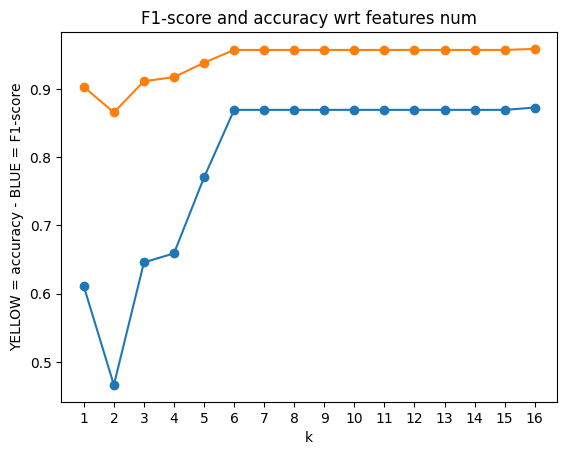

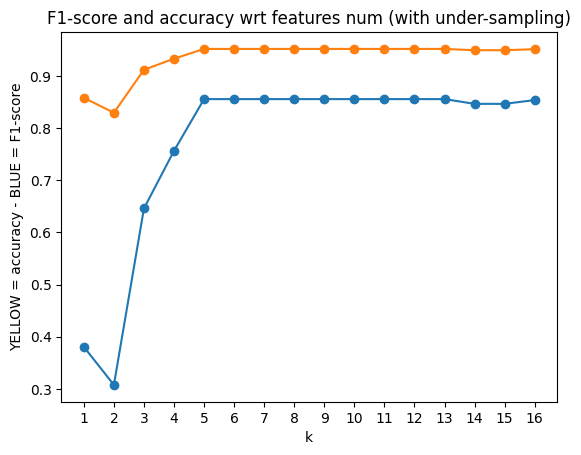

In [ ]:
plot_xy_graphics_fs(result_list, result_list_undersampling)

È possibile osservare che:
* Senza l'applicazione dell'under-sampling, l'F1-score e l'accuracy raggiungono il valore di regime per k=6 e si stabilizzano quasi perfettamente fino a k=15, con un leggerissimo incremento per k=16 (tutte le feature): di conseguenza, se si vuole ridurre il numero delle feature per rendere più efficienti l'addestramento del modello e le predizioni, basta lasciare almeno le 6 feature calcolate con la funzione SelectKBest senza che la qualità del modello degradi significativamente.
* Con l'applicazione dell'under-sampling, l'F1-score e l'accuracy raggiungono il valore di regime per k=5 e si stabilizzano quasi perfettamente fino a k=13, con un leggerissimo decremento subito dopo: di conseguenza, qui sembra del tutto conveniente lasciare le 5 feature calcolate con la funzione SelectKBest.

In [ ]:
migiori_freature(X_training,Y_training,6)

per K: 6
i migliori componenti sono: 
['S1_Light' 'S2_Light' 'S3_Light' 'S5_CO2' 'S6_PIR' 'S7_PIR']


In [ ]:
migiori_freature(X_training_under,Y_training_under,5)

per K: 5
i migliori componenti sono: 
['S1_Light' 'S2_Light' 'S3_Light' 'S5_CO2' 'S7_PIR']


### Feature selection su MLP

In [ ]:
MLP = MLPClassifier(activation="logistic", hidden_layer_sizes=[10,10], learning_rate_init=0.001, beta_1=0.99, beta_2=0.99, random_state=0)
result_list = feature_selection(MLP, X_training, Y_training)

CASO SENZA UNDERSAMPLING
Best number of features: 16
F1-score: 0.8606602681177639
Accuracy: 0.9546127281697089
Feature che rimangono: ['S1_Temp' 'S2_Temp' 'S3_Temp' 'S4_Temp' 'S1_Light' 'S2_Light' 'S3_Light'
 'S4_Light' 'S1_Sound' 'S2_Sound' 'S3_Sound' 'S4_Sound' 'S5_CO2'
 'S5_CO2_Slope' 'S6_PIR' 'S7_PIR']



In [ ]:
result_list_undersampling = feature_selection(MLP, X_training_under, Y_training_under, True)

CASO CON UNDERSAMPLING
Best number of features: 8
F1-score: 0.6604309108647642
Accuracy: 0.900838677849038
Feature che rimangono: ['S1_Temp' 'S1_Light' 'S2_Light' 'S3_Light' 'S3_Sound' 'S5_CO2' 'S6_PIR'
 'S7_PIR']



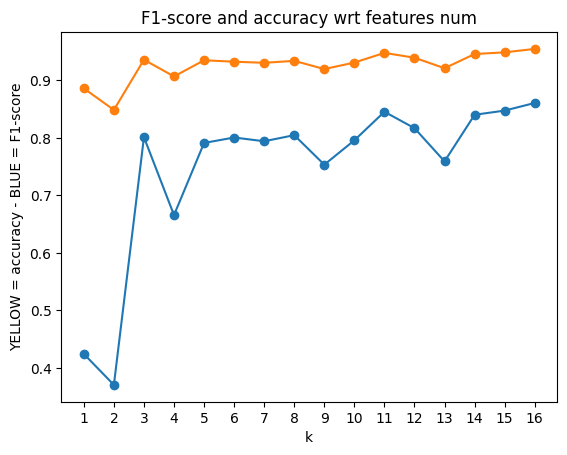

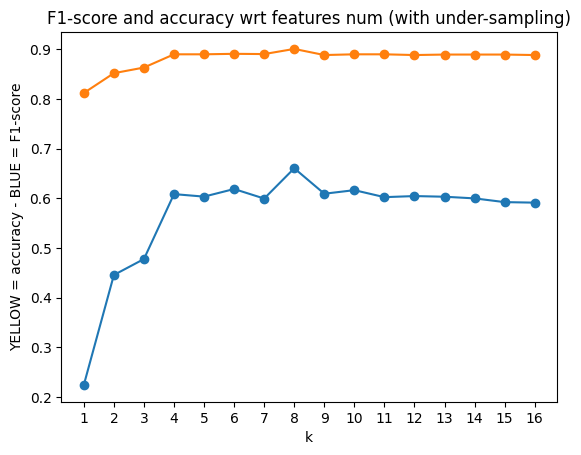

In [ ]:
plot_xy_graphics_fs(result_list, result_list_undersampling)

È possibile osservare che:
* Senza l'applicazione dell'under-sampling, l'F1-score e l'accuracy hanno un andamento oscillante che raggiunge il massimo proprio per k=16.
* Con l'applicazione dell'under-sampling, invece, l'andamento delle metriche prestazionali è più regolare, con solo un picco dato da k=8, per cui sembra conveniente effettuare una riduzione a 8 feature con la funzione SelectKBest.

### Matrice delle correlazioni tra le feature
Di seguito è riportata una matrice indicante quanto sono correlate tra loro le varie feature, e quanto queste ultime sono legate al target. Osservando la matrice, si può concludere che:
* Le feature che misurano una stessa cosa (i.e. le quattro feature sulla temperatura, le quattro feature sulla luminosità e le quattro feature sul rumore), com'era prevedibile, sono altamente correlate tra loro; di fatto, all'interno della matrice vi sono dei 'blocchi' che denotano un'elevata correlazione tra queste feature.
* Le feature che misurano la luminosità della stanza, oltre a essere relativamente correlate alle altre feature, hanno un'alta correlazione soprattutto col target (Room_Occupancy_Count). L'elevata correlazione col target giustifica il fatto che tali feature vengano spesso preferite nell'ambito della feature selection. S4_Light è un'eccezione: probabilmente la lampadina che si trova sulla quarta scrivania viene accesa piuttosto di rado, per cui la luminosità in questa zona della stanza risulta meno dipendente dal numero di persone presenti nell'ufficio e dalle altre feature.

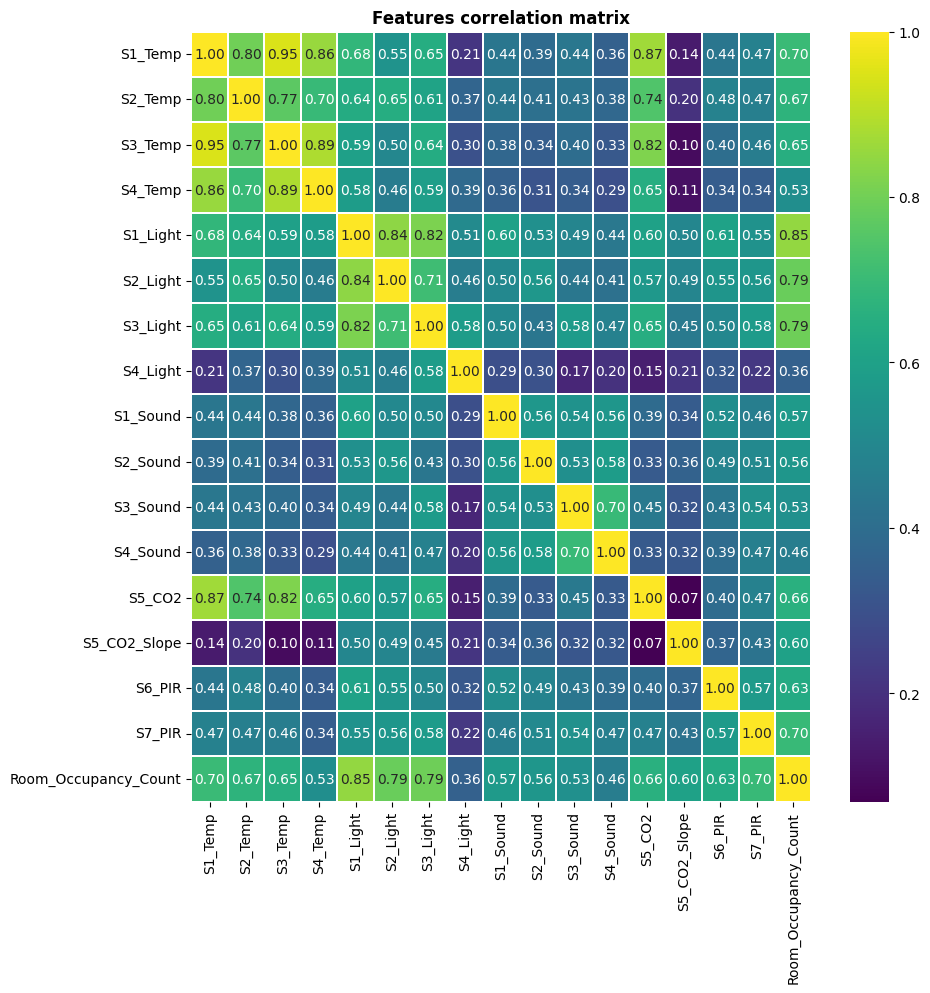

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), linewidths=.3, cmap="viridis", annot=True, fmt=".2f")
plt.title('Features correlation matrix', fontweight="bold")
plt.yticks(rotation=0)
plt.show()

## PCA (Principal Component Analysis)
Per ridurre la dimensionalità del problema e rappresentare gli elementi con un numero minore di feature, è possibile ricorrere anche al Principal Component Analysis (PCA). Questa tecnica di Machine Learning consiste nel proiettare tutti gli elementi su un iperpiano di dimensione minore puntando a minimizzare la somma delle distanze tra gli elementi stessi e le rispettive proiezioni (il che corrisponde a preservare più informazione possibile nella rappresentazione degli elementi).

In [ ]:
result_list = {}

def pca(classificatore):
  #addestrare il modello PCA
  pca = PCA()
  pca.fit(X_training) #su cosa devo vedere i migliori parametri

  #calcolare la varianza spiegata cumulativa (indica quanto sono correlate le feature tra loro)
  explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

  #trovare il numero di componenti che spiega una percentuale significativa della varianza (qui è 99%)
  #sarebbe il numero minimo di feature da mantenere affinché venga preservato almeno il 99% dell'informazione iniziale
  #(ricordi il discorso sugli autovalori nella PCA?)
  n = np.argmax(explained_variance_ratio_cumulative >= 0.99) + 1  #il +1 serve perché l'argmax conta gli indici delle feature (parte da 0)
  print("Numero di feature a seguito dell'applicazione di PCA:", n)
  print("")

  pca_best = PCA(n_components=n)  #ora la dimensionalità viene ridotta da 16 a n.
  X_training_pca = pca.transform(X_training)  #trasformazione del training set
  X_testing_pca = pca.transform(X_testing)    #trasformazione del testing set

  #addestramento + predizione
  classificatore.fit(X_training_pca, Y_training)
  Y_pred=classificatore.predict(X_testing_pca)
  return stampa_metriche(Y_pred=Y_pred, Y_testing=Y_testing)

### PCA su QDA

Numero di feature a seguito dell'applicazione di PCA: 12

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


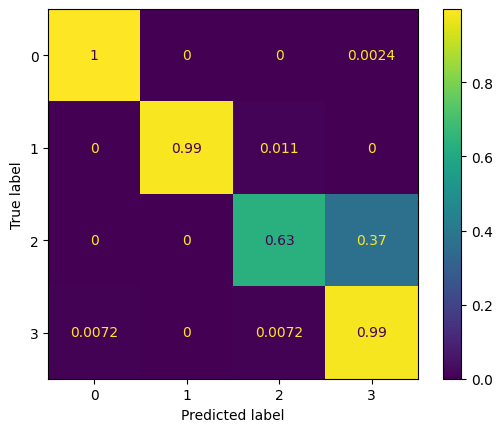


F1-score: 0.8950391293015307
Accuracy: 0.9694129255056734


In [ ]:
QDA = QuadraticDiscriminantAnalysis()
result_list["QDA"] = pca(QDA)

È possibile notare che, con l'applicazione di PCA, il modello QDA non cambia minimamente il suo comportamento. Ciò potrebbe essere dovuto al fatto che QDA, internamente, implementa già un meccanismo di riduzione della dimensionalità, per cui applicarlo anche esternamente non ha un impatto sul classificatore.

### PCA su GNB

Numero di feature a seguito dell'applicazione di PCA: 12

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


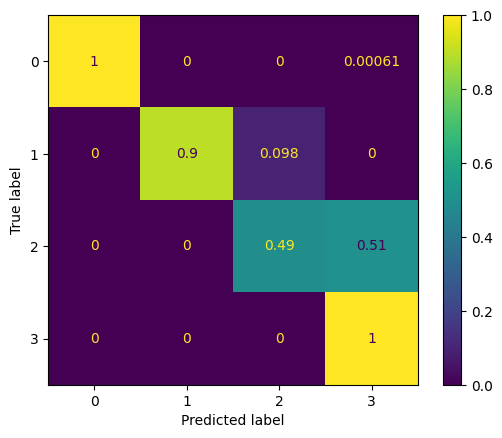


F1-score: 0.8416398235396287
Accuracy: 0.9575727676369018


In [ ]:
GNB = GaussianNB()
result_list["GNB"] = pca(GNB)

Per quanto riguarda GNB, la percentuale di elementi predetti correttamente è rimasta invariata, anche se l'F1-score è diminuito leggermente. Ciò può essere dovuto al fatto che, rispetto al caso senza PCA, il modello ora individua correttamente tre classi anziché due, ma la classe restante (la 2) viene predetta in modo peggiore.

### PCA su SVM

Numero di feature a seguito dell'applicazione di PCA: 12

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


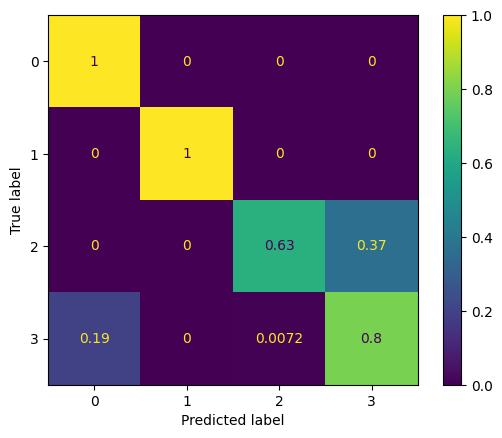


F1-score: 0.8730228989051161
Accuracy: 0.9590527873704983


In [ ]:
SVM = SVC(C=0.25, kernel="linear", degree=1, class_weight="balanced")
result_list["SVM"] = pca(SVM)

SVM, come QDA, si comporta in modo identico con l'applicazione di PCA e senza applicazione di PCA. Analogamente al caso di QDA, ciò potrebbe essere dovuto al fatto che internamente implementa già un meccanismo di trasformazione degli elementi, che ad esempio può portare a una riduzione della dimensionalità.

### PCA su MLP

Numero di feature a seguito dell'applicazione di PCA: 12

METRICHE DEL CLASSIFICATORE SELEZIONATO CALCOLATE SUL TESTING SET
Confusion matrix:


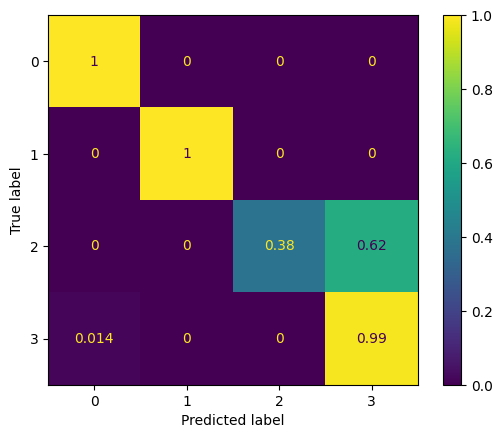


F1-score: 0.8231662246534559
Accuracy: 0.9531327084361125


In [ ]:
MLP = MLPClassifier(activation="logistic", hidden_layer_sizes=[10,10], learning_rate_init=0.001, beta_1=0.99, beta_2=0.99, random_state=0)
result_list["MLP"] = pca(MLP)

Infine, per quanto riguarda MLP, l'accuracy si è ridotta leggerissimamente (circa di 0,1 punto percentuale) ma l'F1-score ha avuto un calo più consistente. In effetti, si è verificato un fenomeno analogo al caso di GNB: rispetto al caso senza PCA, sono migliorate di parecchio le predizioni sulla classe 3 ma sono altrettanto peggiorate le predizioni sulla classe 2.

### Recap su PCA

QDA WITH PCA
F1-score: 0.8950391293015307
Accuracy: 0.9694129255056734

GNB WITH PCA
F1-score: 0.8416398235396287
Accuracy: 0.9575727676369018

SVM WITH PCA
F1-score: 0.8730228989051161
Accuracy: 0.9590527873704983

MLP WITH PCA
F1-score: 0.8231662246534559
Accuracy: 0.9531327084361125



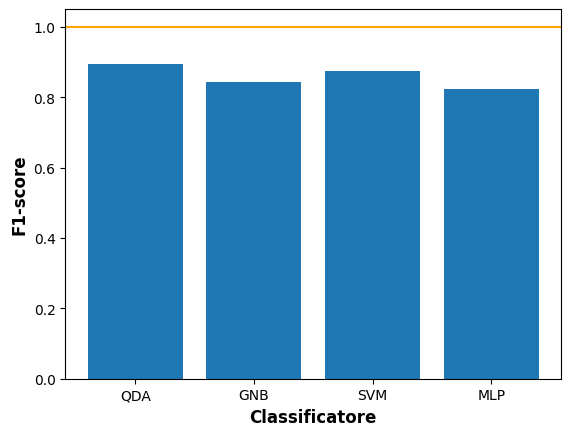

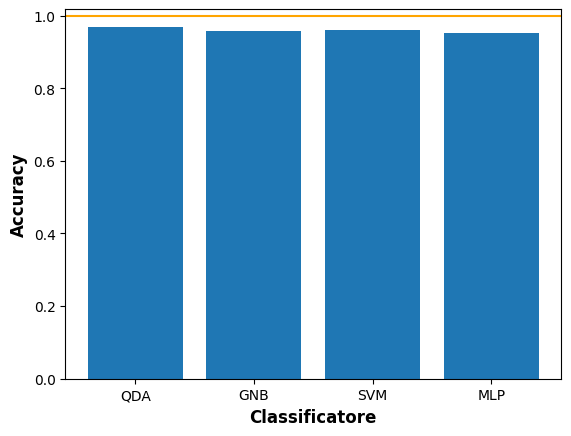

In [ ]:
for classifier in result_list:
  print(classifier, "WITH PCA")
  metrics=result_list[classifier]
  print("F1-score:", metrics['f1'])
  print("Accuracy:", metrics['accuracy'])
  print("")

data_result = pd.DataFrame(result_list)
data_result = data_result.T   #data_result.T = matrice trasposta di data_result

#plot F1-score dei modelli analizzati
plt.bar(x=data_result.index, height=data_result["f1"])
plt.axhline(y=1, color='orange')
plt.xlabel('Classificatore', fontsize="large", fontweight="bold")
plt.ylabel('F1-score', fontsize="large", fontweight="bold")
plt.show()

#plot accuracy dei modelli analizzati
plt.bar(x=data_result.index, height=data_result["accuracy"])
plt.axhline(y=1, color='orange')
plt.xlabel('Classificatore', fontsize="large", fontweight="bold")
plt.ylabel('Accuracy', fontsize="large", fontweight="bold")
plt.show()

## Considerazioni sulla separabilità lineare del data set
A seguito dei risultati che sono stati ottenuti finora, si può notare che tendenzialmente tutti i predittori si comportano estremamente bene sugli elementi realmente appartenenti alle classi 0, 1, mentre fanno molta più fatica a individuare gli elementi realmente appartenenti alle classi 2, 3. Poiché inizialmente l'intero data set era stato suddiviso in training+validation set e testing set in modo tale che al testing set appartenesse il 20% dei dati più recenti di ciascuna delle quattro classi, è possibile sollevare alcune ipotesi:
* Gli ultimi dati nell'ordine temporale potrebbero essere tali che i valori delle loro feature siano maggiormente assimilabili agli elementi delle classi 0, 1.
* Più probabilmente, gli elementi della classe 0 e della classe 1 sono raggruppati in una regione ben definita dello spazio dei punti; d'altra parte, gli elementi della classe 2 e della classe 3 potrebbero essere più "sparsi" e, quindi, più difficili da individuare correttamente.

Per farci un'idea più precisa di come sono distribuiti i vari elementi nello spazio, è possibile verificare se una delle quattro classi è linearmente separabile rispetto alle altre tre. \
Per far ciò, è stato preso il data set originale per intero ed è stato utilizzato per ricavare quattro data set derivati, che sono identici all'originale ma differiscono solo per il target. In particolare, l'i-esimo data set derivato avrà la i-esima classe labelata in un certo modo e tutte le altre classi labelate in un altro modo (in modo che venga distinta esclusivamente l'i-esima classe). A questo punto, lo studio sulla separabilità lineare del data set può essere effettuato sui quattro data set derivati.

**NB**: affinché lo studio fornisca dei risultati affidabili, è necessario trattare ciascun data set derivato per intero (e.g. senza suddivisione in training set e testing set) sia per la fase di addestramento che per la fase di predizione.

In [ ]:
#creazione di data set separati

#le feature sono in comune per tutti
x = df.iloc[:,:-1]

#primo data set: nuova classe 0 := vecchia classe 0; nuova classe 1 := vecchie classi 1,2,3
y0 = df.iloc[:,-1]
y0 = y0.replace(to_replace=[1,2,3], value=1)

#secondo data set: nuova classe 0 := vecchie classi 0,2,3; nuova classe 1 := vecchia classe 1
y1 = df.iloc[:,-1]
y1 = y1.replace(to_replace=[0,2,3], value=0)

#secondo data set: nuova classe 0 := vecchie classi 0,1,3; nuova classe 1 := vecchia classe 2
y2 = df.iloc[:,-1]
y2 = y2.replace(to_replace=[0,1,3], value=0)
y2 = y2.replace(to_replace=2, value=1)

#secondo data set: nuova classe 0 := vecchie classi 0,1,2; nuova classe 1 := vecchia classe 3
y3 = df.iloc[:,-1]
y3 = y3.replace(to_replace=[0,1,2], value=0)
y3 = y3.replace(to_replace=3, value=1)

### Funzioni ausiliarie

In [ ]:
#exec_svc_perceptron_for_linear_sep effettua l'addestramento di SVM e Perceptron su TUTTI i dati del data set,
#valuta i due modelli sempre su TUTTI i dati del data set e restituisce in output le rispettive accuracy ottenute.
def exec_svc_perceptron_for_linear_sep(c, kernel, iter, y):
  svc_test = SVC(C=c, kernel=kernel)
  svc_test.fit(x, y)
  y_pred = svc_test.predict(x)
  accuracy_svc = accuracy_score(y_pred=y_pred, y_true=y)

  perceptron_test = Perceptron(max_iter=iter, n_iter_no_change=iter)
  perceptron_test.fit(x, y)
  y_pred = perceptron_test.predict(x)
  accuracy_perceptron = accuracy_score(y_pred=y_pred, y_true=y)

  return accuracy_svc, accuracy_perceptron

In [ ]:
#plot accuracies wrt binary data sets
def accuracy_bar_plot(accuracy_list, ylabel):
  plt.bar(x=[0,1,2,3], height=accuracy_list)
  plt.axhline(y=1, color='orange')
  plt.xlabel('Class', fontsize="large", fontweight="bold")
  plt.ylabel(ylabel, fontsize="large", fontweight="bold")
  plt.show()

### Applicazione di SVM e percettrone
I modelli di Machine Learning che sono stati utilizzati al fine di valutare la separabilità delle classi all'interno del training set sono la **SVM** e il **percettrone**. Infatti:
* Se il data set è linearmente separabile, SVM è certamente in grado di individuare un iperpiano di separazione che suddivida perfettamente le classi all'interno dello spazio degli elementi. Di fatto, sotto questa ipotesi, lo scopo del modello è quello di far sì che i punti di ciascuna classe siano i più distanti possibile dall'iperpiano di separazione.
* D'altra parte, il percettrone, che è un modello pensato specificatamente per la classificazione binaria, assume dei comportamenti differenti a seconda se il data set è linearmente separabile oppure no: nel primo caso, l'algoritmo della discesa del gradiente che minimizza la funzione costo converge e riesce a trovare un iperpiano di separazione che suddivida perfettamente le due classi all'interno dello spazio dei punti; nel secondo caso, invece, l'algoritmo della discesa del gradiente potrebbe oscillare indefinitamente e non arrivare mai a una soluzione ottima.

Per queste ragioni, SVM e percettrone possono essere considerati come i due modelli migliori per identificare un data set linearmente separabile. \
Chiaramente, il criterio più immediato che può essere sfruttato per stabilire se un data set è linearmente separabile è l'accuracy: se a seguito delle predizioni su TUTTI gli elementi del data set l'accuracy risulta pari a 1, vuol dire che esiste un iperpiano lineare in grado di separare perfettamente gli elementi appartenenti alle due classi diverse (e viceversa).

In [ ]:
#addestramento ed esecuzione dei modelli SVM e Perceptron su tutti i data set binari appena ottenuti
#con lo scopo di determinare se c'è una qualche classe del data set originario linearmente separabile wrt le altre
c = 1000
kernel = "linear"
iter = 1000
list_perceptron = []
list_svc = []

#primo data set
accuracy_svc_0, accuracy_perc_0 = exec_svc_perceptron_for_linear_sep(c, kernel, iter, y0)
list_svc.append(accuracy_svc_0)
list_perceptron.append(accuracy_perc_0)

#secondo data set
accuracy_svc_1, accuracy_perc_1 = exec_svc_perceptron_for_linear_sep(c, kernel, iter, y1)
list_svc.append(accuracy_svc_1)
list_perceptron.append(accuracy_perc_1)

#terzo data set
accuracy_svc_2, accuracy_perc_2 = exec_svc_perceptron_for_linear_sep(c, kernel, iter, y2)
list_svc.append(accuracy_svc_2)
list_perceptron.append(accuracy_perc_2)

#quarto data set
accuracy_svc_3, accuracy_perc_3 = exec_svc_perceptron_for_linear_sep(c, kernel, iter, y3)
list_svc.append(accuracy_svc_3)
list_perceptron.append(accuracy_perc_3)

clear_output()

SVM - accuracies wrt 4 binary data sets: [0.9998025471418699, 0.9998025471418699, 0.9615954190936914, 0.9925955178201205]
Perceptron - accuracies wrt 4 binary data sets: [0.9991114621384145, 0.9997038207128048, 0.9133181952808767, 0.9859808470727613]



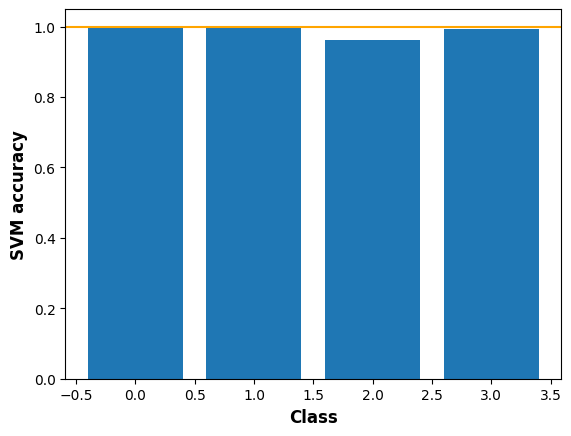

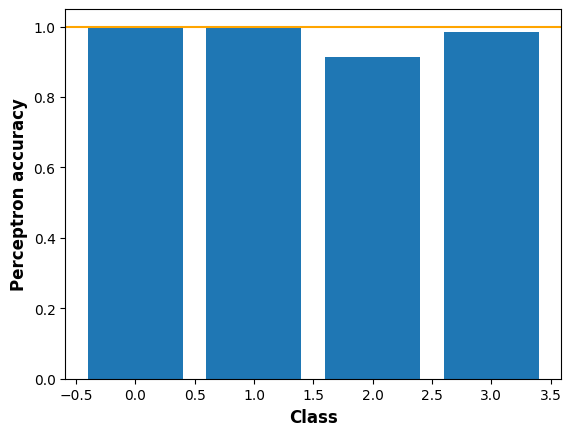

In [ ]:
print("SVM - accuracies wrt 4 binary data sets:", list_svc)
print("Perceptron - accuracies wrt 4 binary data sets:", list_perceptron)
print("")

accuracy_bar_plot(list_svc, "SVM accuracy")
accuracy_bar_plot(list_perceptron, "Perceptron accuracy")

Com'era prevedibile, dai risultati ottenuti emerge che le classi 2 e 3 non sono affatto linearmente separabili: i modelli SVM e Perceptron non riescono a distinguere perfettamente ciascuna di queste due classi da tutte le altre. \
In realtà, anche se per poco, neanche le classi 0 e 1 risultano linearmente separabili: per i due data set in cui sono state separate rispettivamente la classe 0 e la classe 1 dalle altre classi, i due modelli in esame danno un'accuracy maggiore di 0.999 ma non esattamente pari a 1: ciò vuol dire che, in tutto il data set, c'è un'esigua quantità di elementi posizionati in modo tale da rendere impossibile la lineare separabilità della classe 0 (e della classe 1) da tutte le altre classi. Molto probabilmente, questi pochi elementi rientrano per lo più in quello che era il training+validation set quando sono stati analizzati tutti i modelli di Machine Learning: di fatto, le varie predizioni che erano state fatte sul testing set riconoscevano perfettamente soprattutto gli elementi appartenenti alla classe 0 (ma spesso e volentieri anche gli elementi appartenenti alla classe 1).